# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
import datetime

# data visualization
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns 
from pylab import rcParams

# statistics
from statsmodels.tsa.stattools import acf, adfuller

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

# machine learning: 
import xgboost as xgb
from xgboost.sklearn import XGBRegressor #

# prophet by Facebook
from fbprophet import Prophet

# mediciones de Error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Optimización de Hiperparámetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


#sns.set(style="white", context="talk")
sns.set()
# Definición de Tipo, tamaño, color y ancho de las Fuentes para los títulos de los gráficos
title_font= {"family" : "Cambria",
             "size" : 18,
             "color" : "black",
             "weight" : "bold"}

plt.rcParams.update({'figure.figsize': (10,6), 'figure.dpi': 120})

import warnings
warnings.filterwarnings("ignore")

In [2]:
def elimino_outliers(dataset,var):
    '''
    Dado un dataset y un feature 
    devuelve la mascara(filtro) 
    con los datos a eliminar en 
    ese feature del dataset aplicando
    el rango intercuantílico.
    '''
    
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

In [3]:
def MAPE(actual, pred):
    '''
    El Error Porcentual Absoluto 
    Medio (MAPE o Mean Absolute Percentage Error)    
    '''
    
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [4]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [5]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [6]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [7]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

In [8]:
data_2019.shape

(812153, 10)

In [9]:
data_2018.shape

(1375908, 10)

In [10]:
data_2017.shape

(1372645, 10)

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [11]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [12]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [13]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [14]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [15]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [16]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [17]:
dataset.shape

(238869, 5)

In [18]:
# Verifico la existencia de nulos en el dataset
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha2            0
dtype: int64

In [19]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [20]:
#Reordenamos el dataset por fecha. Esto es fundamental cuando trabajamos con serie de tiempo.
dataset.sort_values('fecha', inplace = True);
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

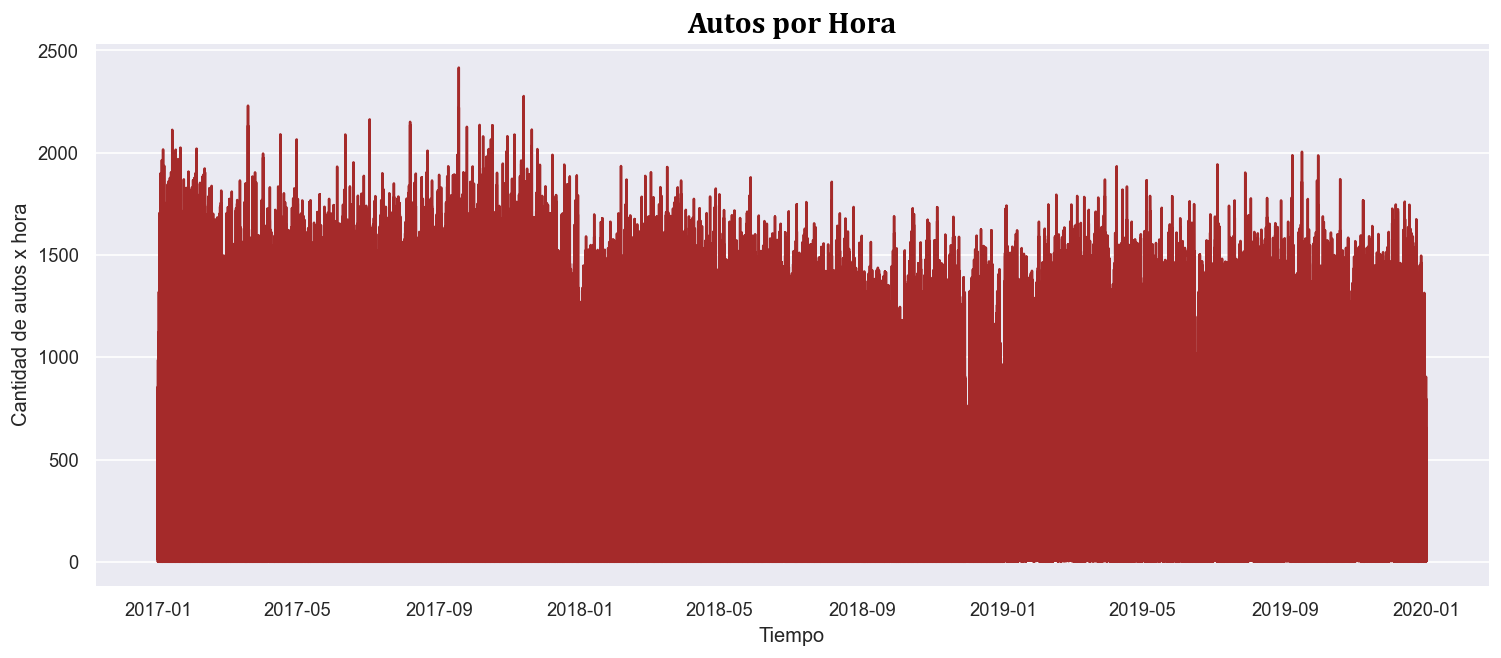

In [21]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos, color='brown')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos x hora')
plt.title('Autos por Hora', fontdict=title_font)
plt.grid(axis='x')
plt.show();

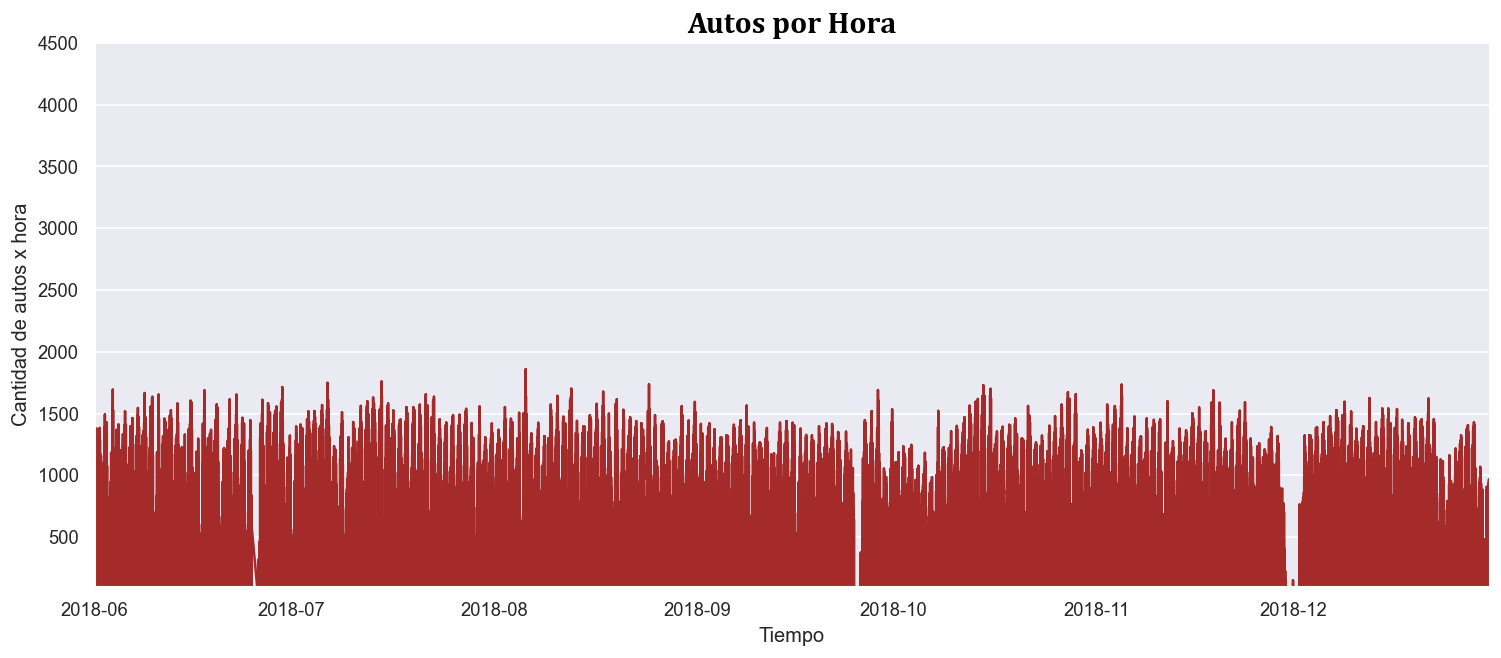

In [22]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos, color='brown')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos x hora')
plt.title('Autos por Hora', fontdict=title_font)
plt.ylim(100,4500) 
plt.xlim(datetime.date(2018,6,1), datetime.date(2018,12,31))
plt.grid(axis='x')
plt.show();

En el primer gráfico observamos las serie de datos representada en su frecuencia original de muestreo que en este caso es hora. En dicho gráfico se puede observar sectores blancos que me están indicando la ausencia de información o bien valores atípicos para lograr una mejor visualización modifico el rango de los ejes x e y. En este segundo gráfico se puede observar que en  julio, octubre y sobre todo en diciembre del 2018 tenemos valores atípicos. Más adelante realizaré su tratamiento.

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


In [24]:
# Lo primero que debemos hacer es convertir la columna fecha, hora_fin en formata dd-mm-yyyy
dataset['fecha'] = pd.to_datetime(dataset['fecha'])

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


In [26]:
dataset.head(10)

dia    sentido tipo_vehiculo  cantidad_pasos      fecha
0  Domingo  Provincia        Pesado               1 2017-01-01
1  Domingo  Provincia       Liviano               9 2017-01-01
2  Domingo  Provincia       Liviano             644 2017-01-01
3  Domingo  Provincia        Pesado               6 2017-01-01
4  Domingo  Provincia        Pesado               1 2017-01-01
5  Domingo  Provincia        Pesado               2 2017-01-01
6  Domingo     Centro       Liviano              23 2017-01-01
7  Domingo     Centro        Pesado               1 2017-01-01
8  Domingo     Centro        Pesado              21 2017-01-01
9  Domingo     Centro        Pesado              10 2017-01-01

In [27]:
# Cambio el indice del dataset por el campo fecha.
dataset_n = dataset.set_index('fecha')
dataset_n.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               '2017-01-01 00:00:00', '2017-01-01 00:00:00',
               ...
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 21:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 22:00:00',
               '2019-12-31 22:00:00', '2019-12-31 22:00:00',
               '2019-12-31 23:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='fecha', length=238869, freq=None)

# Análisis de Exploratorio de los Datos

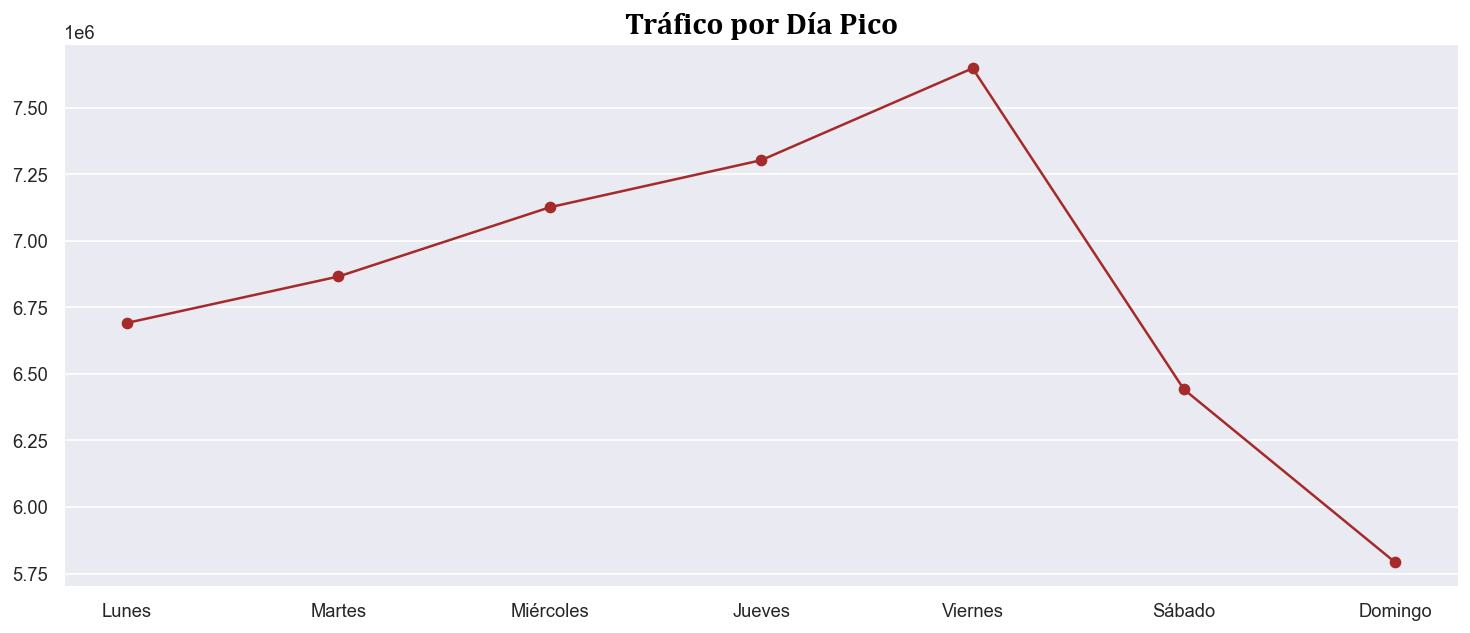

In [28]:
plt.figure(figsize = (15,6))
by_weekday = dataset_n.groupby(dataset_n.index.dayofweek).sum()
by_weekday.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.plot(by_weekday, color='brown', marker='o')
plt.title('Tráfico por Día Pico', fontdict=title_font)
plt.grid(axis='x')
plt.show();

* Con respecto al **tráfico diario** se puede observar que los días de la semana con `mayor tráfico` son los `Viernes` mientras que los días de `menor tráfico` son los días `Domingo`. Además se observa como va decreciendo de año a año el tráfico vehícular.

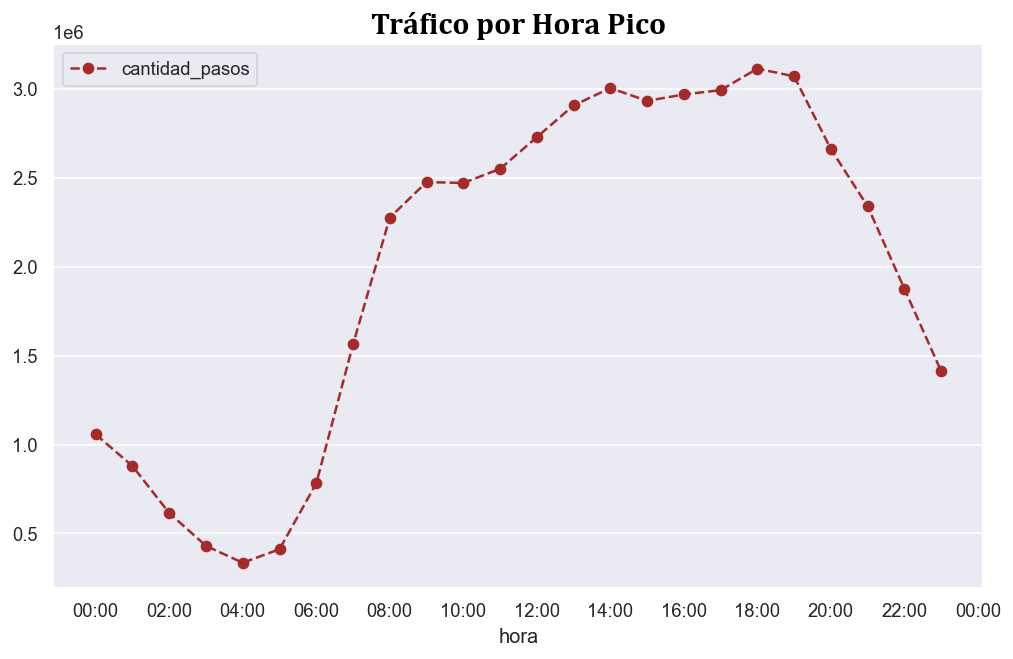

In [29]:
by_time = dataset_n.groupby(dataset_n.index.time).sum()
hourly_ticks = 2 * 60 * 60 *  np.arange(13)
by_time.plot(xticks=hourly_ticks, style='--o', color='brown')
plt.title('Tráfico por Hora Pico', fontdict=title_font)
plt.xlabel('hora')
plt.grid(axis='x')
plt.show();

* En el  gráfico superior se observa el **tráfico por hora pico** que esta dado entre la franja horaria de las `8hs y 19hs`. Comienza a crecer a las 6 de la mañana, se mantiene oscilante durante el día y empieza a decrecer a partir de las 18hs. Esto efectivamente concuerda con el inicio y fin de la jornada laboral.

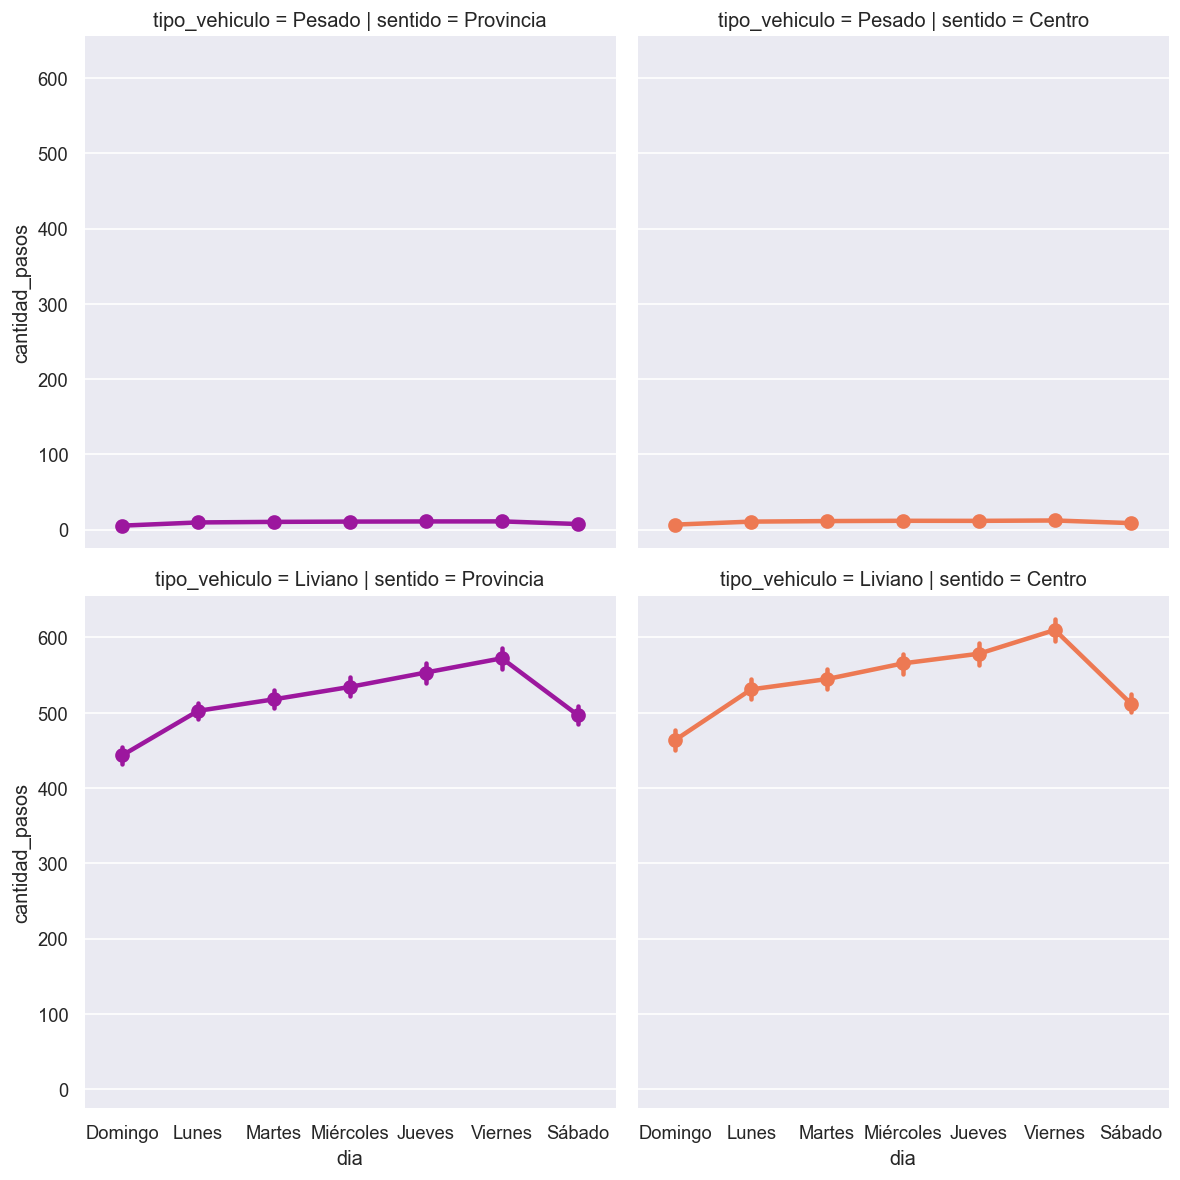

In [30]:
sns.factorplot(data = dataset_n, x = 'dia', y = 'cantidad_pasos', 
               col = 'sentido', 
               palette = 'plasma',
               hue = 'sentido',
               row = 'tipo_vehiculo', 
               color = 'c');

* Mediante el gráfico superior se puede observar `cantidad de pasadas de acuerdo al sentido y al tipo de vehículo por días de semana`. Como vemos el número de pasadas de vehículos pesados es muy baja, tanto sentido a Capital como a provincia mientras que la número de pasadas de vehículos livinos es muy alto comportándose igual tanto sentido a Capital como a provincia y en ambos se visualiza nuevamente que el flujo de vehículos comienza a crecer a partir del día domingo , creciendo día a día hasta llegar al pico el día Viernes y ahí empieza a decrecer.

# Estudio los Componentes del Dataset 

Lo realizaré a través de la utilización de la librería de `Statsmodels`, la cual posee una función que descompone a la serie de datos en sus componentes:

* Estacionalidad
* Tendencia 
* Ruido

* Para lograr una mejor visualización de los datos aplicaré al dataset un resampleo diario ya que no sólo me permitirá tener una mejor comprensión de  mis datos sino también la posibilidad de resumir información en una granularidad de tiempo más grande, en este caso `Día`. Y como estoy trabajando con cantidad de pasadas de autos aplicaré como función de agregación la suma y así logro unificar mis datos día a día. 

In [31]:
#Resampleamos nuestros datos para agrupar por DIA
diario = dataset_n.resample('D').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

* Como se puede observar ahora tengo resumida la información por día. Ahora voy a descomponer el dataset resampleado por día para estudiar sus componentes.

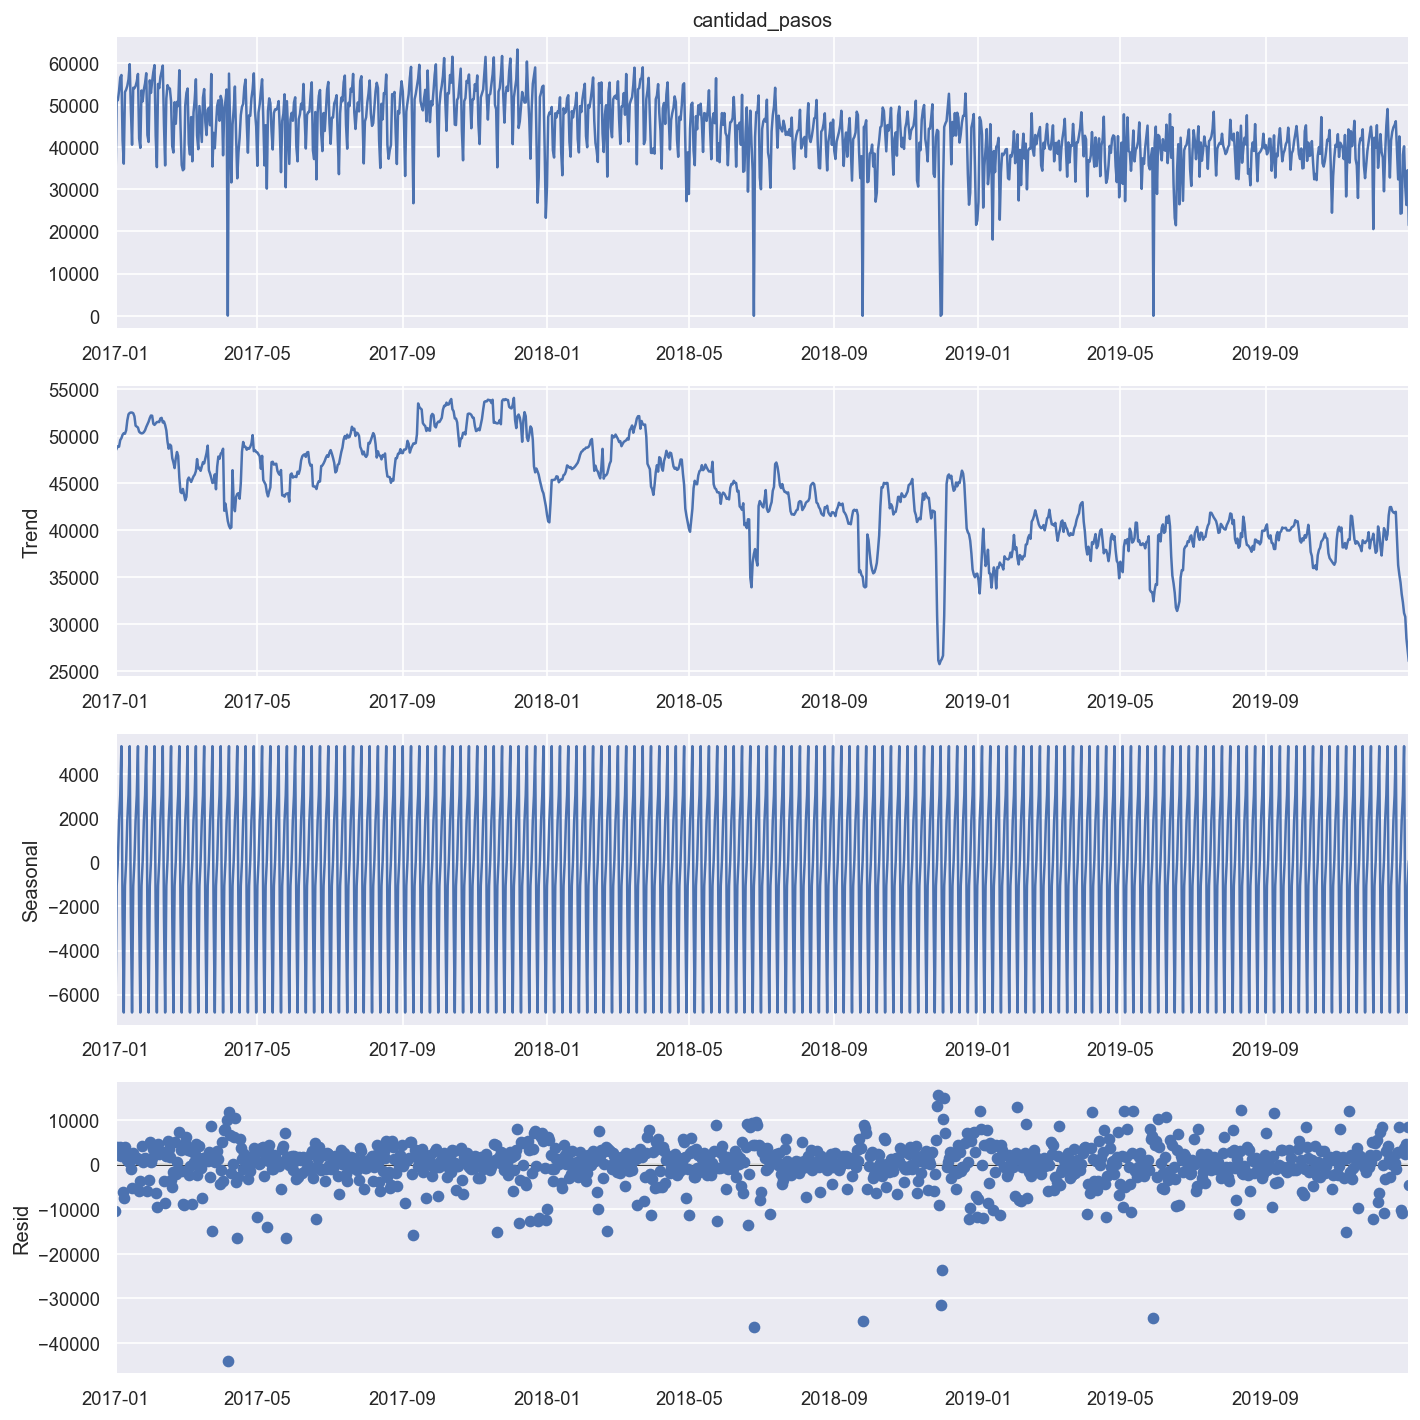

In [32]:
result = seasonal_decompose(diario.cantidad_pasos, extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.grid(axis='x')
plt.show();

* La función de descomposición nos presenta un gráfico por cada componenete de la serie. En cuanto a la tendencia, la cual nos indica la dirección global que está tomando la serie, se puede observar que es `decreciente` y la misma no se mantiene 'recta' en el tiempo esto me indica que `no es estacionaria`. Pero hemos observado en gráficos superiores los días y horas picos de mayor tráfico de autos, en este caso podemos decir que tiene una estacionalidad semanal o diaria, pero también pudimos observar que dentro de cada día también hay mayor tráfico en las horas pico, en este caso nuestra estacionalidad es horaria. En resumen, la serie no es estacionaria en la media pero variando o modificando la visualización de la misma se puede observa que por día o por semana encontramos  patrones que me ayudaran a entender y estudiar mejor los datos  y de esta manera podría lograr predicciones más acertadas sobre su comportamiento.

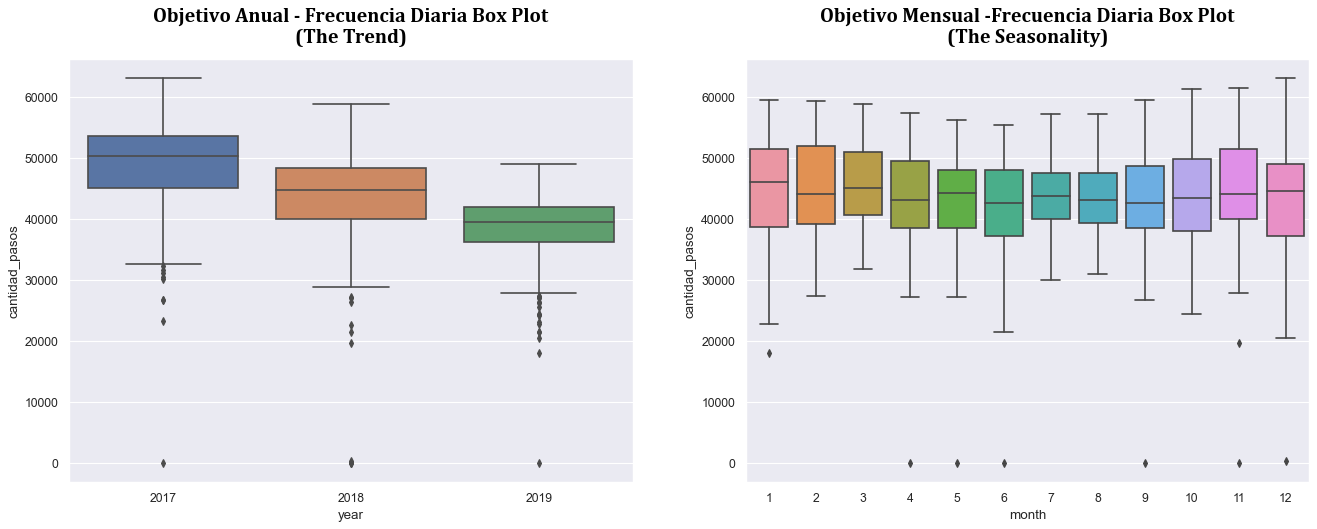

In [33]:
# Visaulizo los datos Por Año y Mes 
diario['year'] = diario.index.year
diario['month'] = diario.index.month
years = diario['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='cantidad_pasos', data=diario, ax=axes[0])
sns.boxplot(x='month', y='cantidad_pasos', data=diario)

# Set Title
axes[0].set_title('Objetivo Anual - Frecuencia Diaria Box Plot\n(The Trend)', fontdict=title_font, pad=15 ); 
axes[1].set_title('Objetivo Mensual -Frecuencia Diaria Box Plot\n(The Seasonality)', fontdict=title_font, pad=15 )
plt.show();

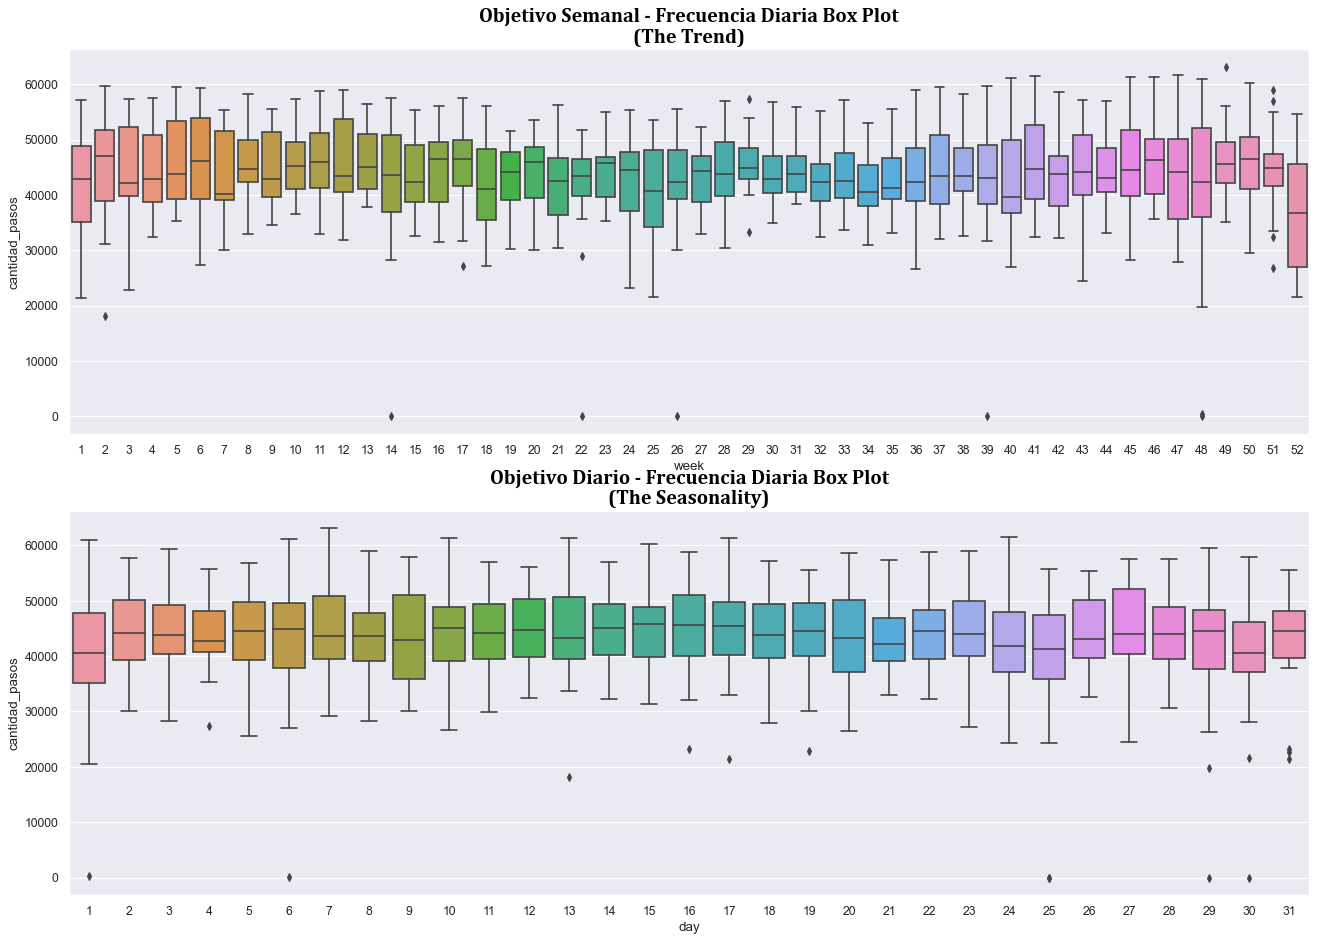

In [34]:
# Visulizando los datos por Semanas y Días 
diario['week'] = diario.index.week
diario['day'] = diario.index.day
diario['month']= diario.index.month

# Draw Plot
fig, axes = plt.subplots(2, 1, figsize=(20,7*2), dpi= 80)
sns.boxplot(x='week', y='cantidad_pasos', data=diario, ax=axes[0])
sns.boxplot(x='day', y='cantidad_pasos', data=diario)

# Set Title
axes[0].set_title('Objetivo Semanal - Frecuencia Diaria Box Plot\n(The Trend)', fontdict=title_font ); 
axes[1].set_title('Objetivo Diario - Frecuencia Diaria Box Plot\n(The Seasonality)', fontdict=title_font)
plt.show();

* Mediante el gráfico de boxplot agrupo los datos en intervalos estacionales y de esta manera se observa cómo se distribuyen los valores dentro de un año o un mes determinado y cómo se comparan a lo largo del tiempo. 

     * Boxplot Anual:Se evidencia la tendencia decreciente de pasadas de autos año a año. Esto se debe principalmente a que estamos analizando la forma de pago efectivo esto confirma la tendencia actual a utilizar otro medio de pago distinto al efectivo.
     * Boxplot Mensual:Se observa como disminuye en los meses de junio-julio dado la temporada de vacaciones invernales.
     * Boxplot Semanal: se observa como la tendencia anual representada por semanas presenta fluctuaciones que ponen en evidencia el movimiento vehicular que se repite semana a semana.
                  
* Otro punto a resaltar es la detección de los valores atípios que en este caso quedan en evidencia en este tipo de gráficos y a continuación realizaré su tratamiento.

* Considero que el mejor patron para analizar mi serie es el día ya que a nivel semanal o mensual es dificil encontrar un patron en los datos además es lógico realizar este análisis día a día porque su comportamiento se repite semana a semana como vimos el el gráfico de días picos y de este modo lograré un mejor entrenamiento del modelo que voy a definir.

## Análisis de Valores Atípicos o Outliers

* Mi siguiente paso será analizar los outliers que había detectado en los gráficos superios.

In [35]:
#Para ello utilizaré la función elimino_outliers que implementa los rangos interquantilicos 
dataset_outliers = elimino_outliers(diario,'cantidad_pasos')
dataset_outliers.sum()

16

In [36]:
# Imprimo los outliers detectado
diario[dataset_outliers]

cantidad_pasos  year  month  week  day
fecha                                             
2017-04-06              40  2017      4    14    6
2017-12-31           23229  2017     12    52   31
2018-06-25               0  2018      6    26   25
2018-09-25               0  2018      9    39   25
2018-11-29           19728  2018     11    48   29
2018-11-30               0  2018     11    48   30
2018-12-01             350  2018     12    48    1
2018-12-30           21559  2018     12    52   30
2018-12-31           22599  2018     12     1   31
2019-01-13           18076  2019      1     2   13
2019-01-19           22774  2019      1     3   19
2019-05-29               0  2019      5    22   29
2019-06-16           23190  2019      6    24   16
2019-06-17           21469  2019      6    25   17
2019-12-01           20553  2019     12    48    1
2019-12-31           21447  2019     12     1   31

 * Investigando que paso en esos días que no hubo tráfico se encontró que corresponden a días de paro general, otro correspode al día de la cumbre del G20 lo que justifica el cierre del peaje o bien el no paso de vehículos. Los días con mayores valores corresponden a fecha tales como fin de año donde mucha gente viaje a otros lugares para pasar las fiestas o por comienzo de vacaciones.
 
 * El siguiente paso será reemplazar los outliers por NAN para luego aplicar la función de pandas `interpolate` para cubrir dichos valores. El metodo elegido es `time` el cual trabaja con datos diarios en un intervalo de tiempo y de esta manera completa los datos faltantes y normaliza la serie de datos.

In [37]:
# Remplazo los outliers por nan  y aplico la interpolacion a la serie
diario[dataset_outliers] = np.nan
print(diario.isnull().sum())
diario = diario.interpolate(method='time')
print(diario.isnull().sum())

cantidad_pasos    16
year              16
month             16
week              16
day               16
dtype: int64
cantidad_pasos    0
year              0
month             0
week              0
day               0
dtype: int64


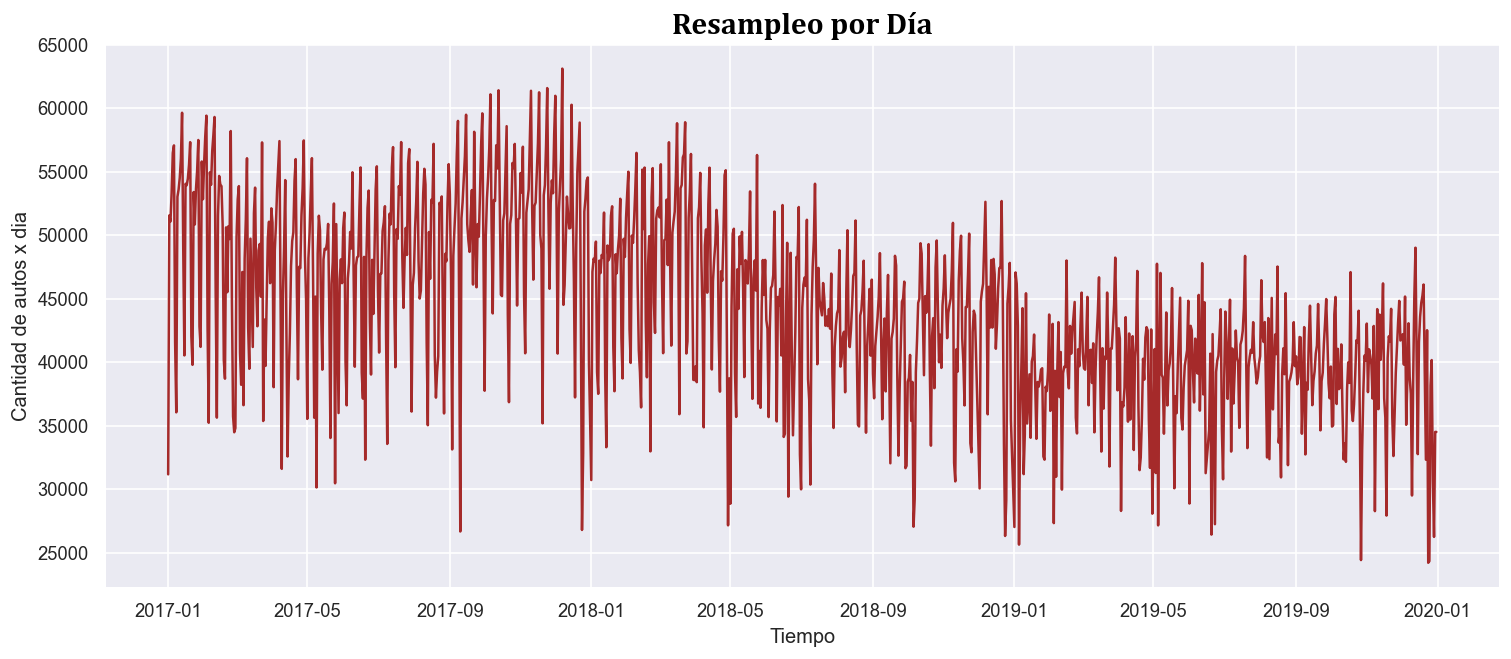

In [38]:
# Visulizo nuevamente los datos pero sin los outliers
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,color='brown')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos x dia')
plt.title('Resampleo por Día', fontdict=title_font)
plt.show();

* Nuevamente se observa como año a año el flujo vehícular va decreciendo y a nivel del movimiento mensual durante el año se observa que los meses también presentan fluctuaciones encontrando meses con menor flujo vehícular que otros.

## Analizo la Autocorrelación mediante el uso de la librería stadmodel 

Es útil estudiar el concepto de la autocorrelación de los valores ya que esto significa en otras palabras que el futuro se parece al pasado. 

Como estoy trabajando con la frecuencia DIARIA determino una ventana de 180 días 

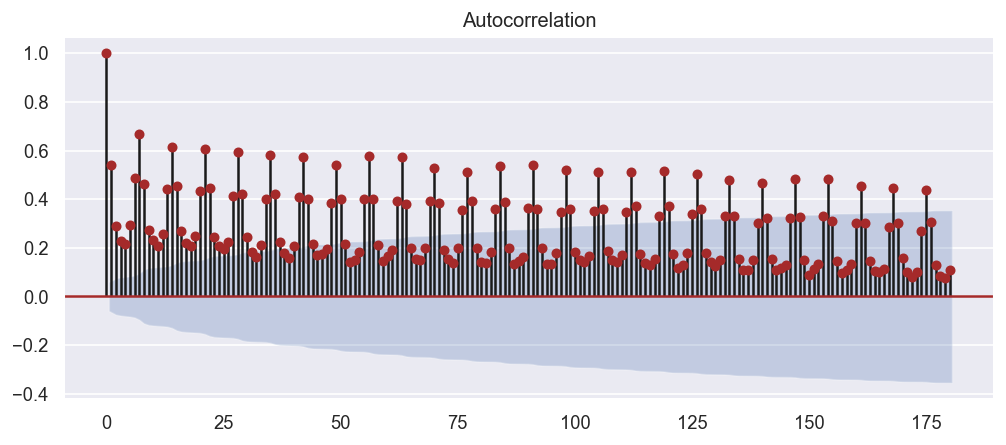

In [39]:
# Para predecir todo mi dataset 
nlags = 180
plt.figure(figsize = (10, 4))
plot_acf(diario.cantidad_pasos, lags =nlags, ax = plt.gca(), color = 'brown')
plt.grid(axis='x')
plt.show();

* Se observa un ciclo que se repite cada 7 días, esta representado por los picos. Esto confirma que logro la estacionalidad a través de los días.

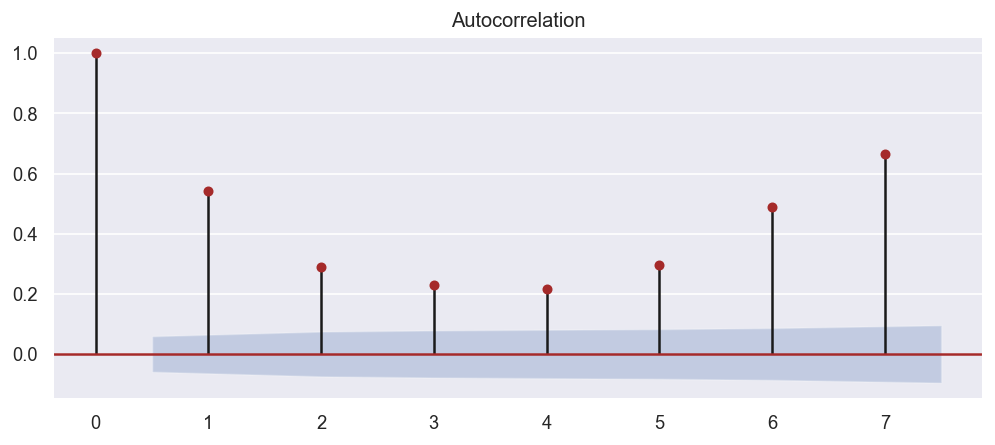

In [40]:
# Para analizar mi dataset aplicaré una ventana a 7 días
nlags = 7
plt.figure(figsize = (10, 4))
plot_acf(diario.cantidad_pasos, lags =nlags, ax = plt.gca(), color = 'brown')
plt.grid(axis='x')
plt.show();

* Cada pico que se eleva por encima o por debajo de las imagen sombreada se considera estadísticamente significativo, es decir diferente de cero. Si un pico es significativamente diferente de cero, esto es evidencia de autocorrelación.

* La autocorrelación es simplemente la correlación de una serie con sus propios retrasos. Si una serie está significativamente autocorrelacionada, eso significa que los valores previos de la serie (lags) pueden ser útiles para predecir el valor actual.

In [41]:
diario.head()

cantidad_pasos    year  month  week  day
fecha                                               
2017-01-01         31183.0  2017.0    1.0  52.0  1.0
2017-01-02         51568.0  2017.0    1.0   1.0  2.0
2017-01-03         51093.0  2017.0    1.0   1.0  3.0
2017-01-04         53332.0  2017.0    1.0   1.0  4.0
2017-01-05         56486.0  2017.0    1.0   1.0  5.0

## Predicción a Futuro

## Predicción del último trimestre del 2019

* Un detalle muy importante a la hora de trabajar con modelos para predecir series de tiempo consiste en tener especial atención a qué parte de nuestros datos usamos como train y cuál como test. A diferencia de los otros modelos aca no podemos trabajar con una elecccion aleatoria en la división de los datos de entrenamiento y de test. En el caso de las series de tiempo y el problema de predicción a futuro, nuestra porción de testeo va a ser siempre los datos más actuales. Existen dos maneras o esquemas de validación  uno es el de ventana deslizante (One-Stpe Prediction) y la otra el de encadenamiento hacia adelante (Multi-Step Prediction) y aplicaré las dos para determinar con cual predice mejor el modelo elegido.
* Para ambos casos debo definir una ventana(lag) con la cual entrenaré mi modelo. Elijo como ventana 365 días ya que considero que con esa información el modelo podra aprender mejor y así arrojará predicciones más certeras.

     

### One-Step Prediction


In [42]:
senial = diario.cantidad_pasos

In [43]:
senial.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

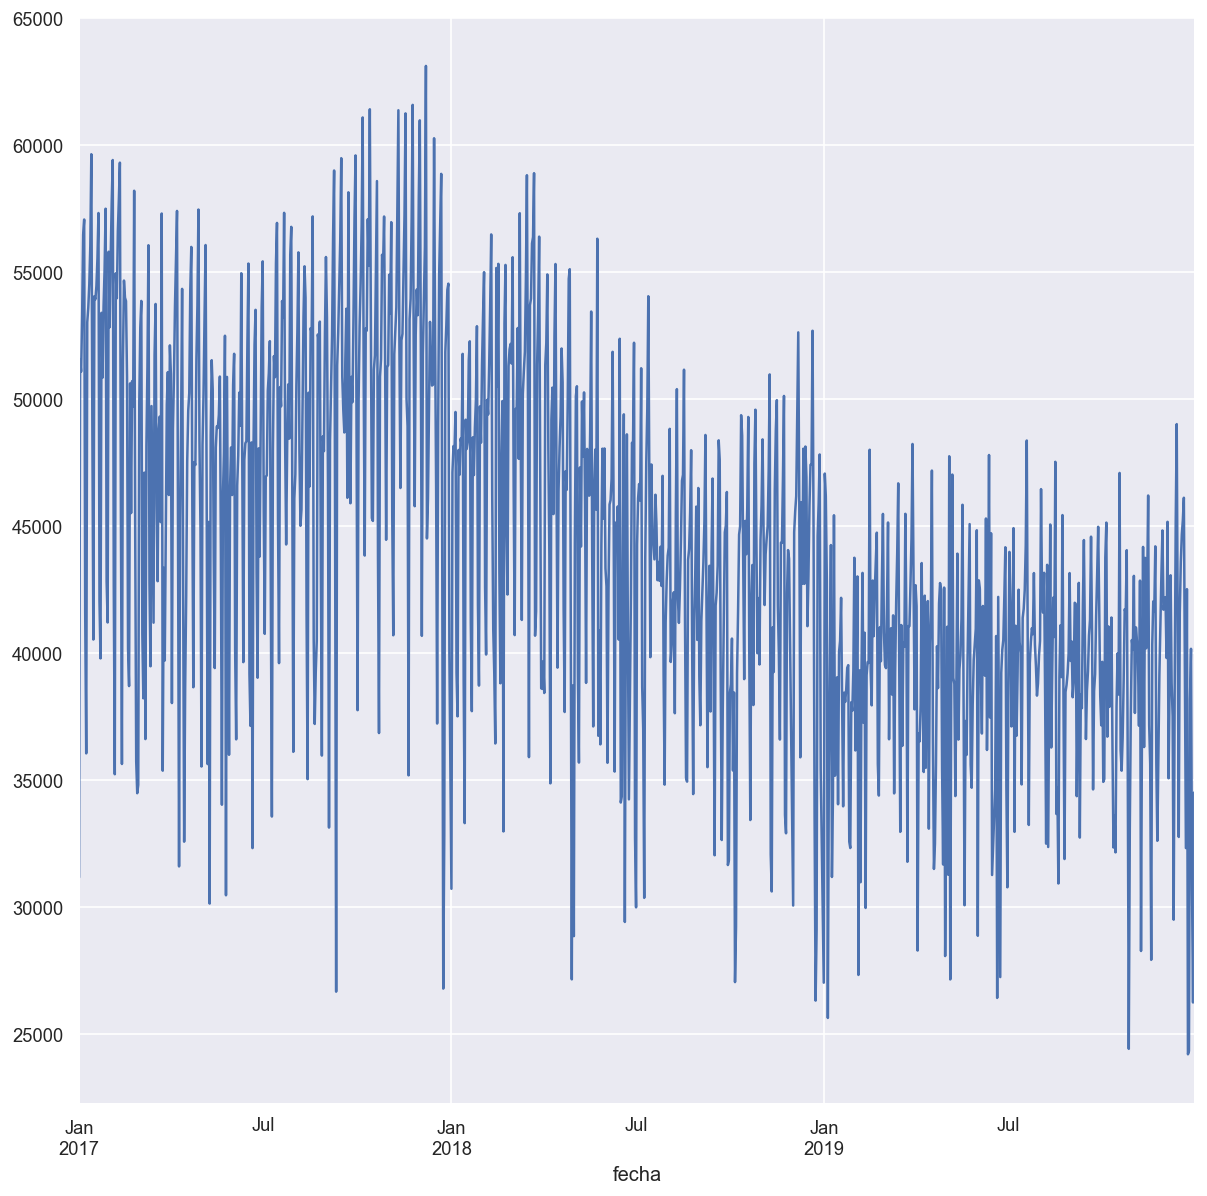

In [44]:
senial.plot()

In [45]:
# Mi ventana con la cual entrenaré mi modelo.Defino cuántos valores hacia atrás tomo para predecir el valor siguiente.
look_back = 365

In [46]:
#Creamos los X e y con ceros para luego llenar con los datos. 
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [47]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [48]:
print(X)

[[31183.         51568.         51093.         ... 54556.
  39969.         35352.        ]
 [51568.         51093.         53332.         ... 39969.
  35352.         30735.        ]
 [51093.         53332.         56486.         ... 35352.
  30735.         47130.        ]
 ...
 [47832.         35446.         32643.33333333 ... 24349.
  38168.         40182.        ]
 [35446.         32643.33333333 29840.66666667 ... 38168.
  40182.         30681.        ]
 [32643.33333333 29840.66666667 27038.         ... 40182.
  30681.         26259.        ]]


In [49]:
print(y)

[30735.         47130.         48162.         47953.
 49505.         39235.         37522.         48010.
 47033.         48454.         48229.         51792.
 38943.         33319.         49201.         48048.
 48340.         51548.         52287.         41208.
 37727.         48508.         47019.         48876.
 49963.         52881.         41907.         38733.
 49726.         48296.         51377.         53306.
 55008.         42606.         39956.         49983.
 49407.         51323.         53707.         56494.
 46189.         40941.         39217.         36454.
 55174.         50497.         55336.         43231.
 38824.         47717.         49936.         32992.
 52997.         55294.         44712.         42318.
 51311.         51972.         52184.         51412.
 55596.         46572.         40721.         49620.
 49692.         52810.         47659.         57329.
 48079.         41317.         50217.         51112.
 51868.         54717.         58825.         

In [50]:
# Definimos nuestros datos de Train y Test 
N_train = (365*2) + (364-92) - look_back # cantidad de instancias que vamos a usar para entrenar.Son 2 años y 9 meses( 637 días)
N_test = 92  #cantidad de puntos que vamos a usar para evaluar (3 meses -- 92 días)
N_total = N_train + N_test
print(N_train)
print(N_test)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

637
92
1094
(637, 365) (637,)
(92, 365) (92,)


In [51]:
# Defino el modelo con los valores por defecto, es decir, sin la definición de ningún hiperparametro.
xr = xgb.XGBRegressor()

In [52]:
# Entreno el modelo
xr.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# Predigo 
y_pred = xr.predict(X)
y_train_pred = xr.predict(X_train)
y_test_pred = xr.predict(X_test)

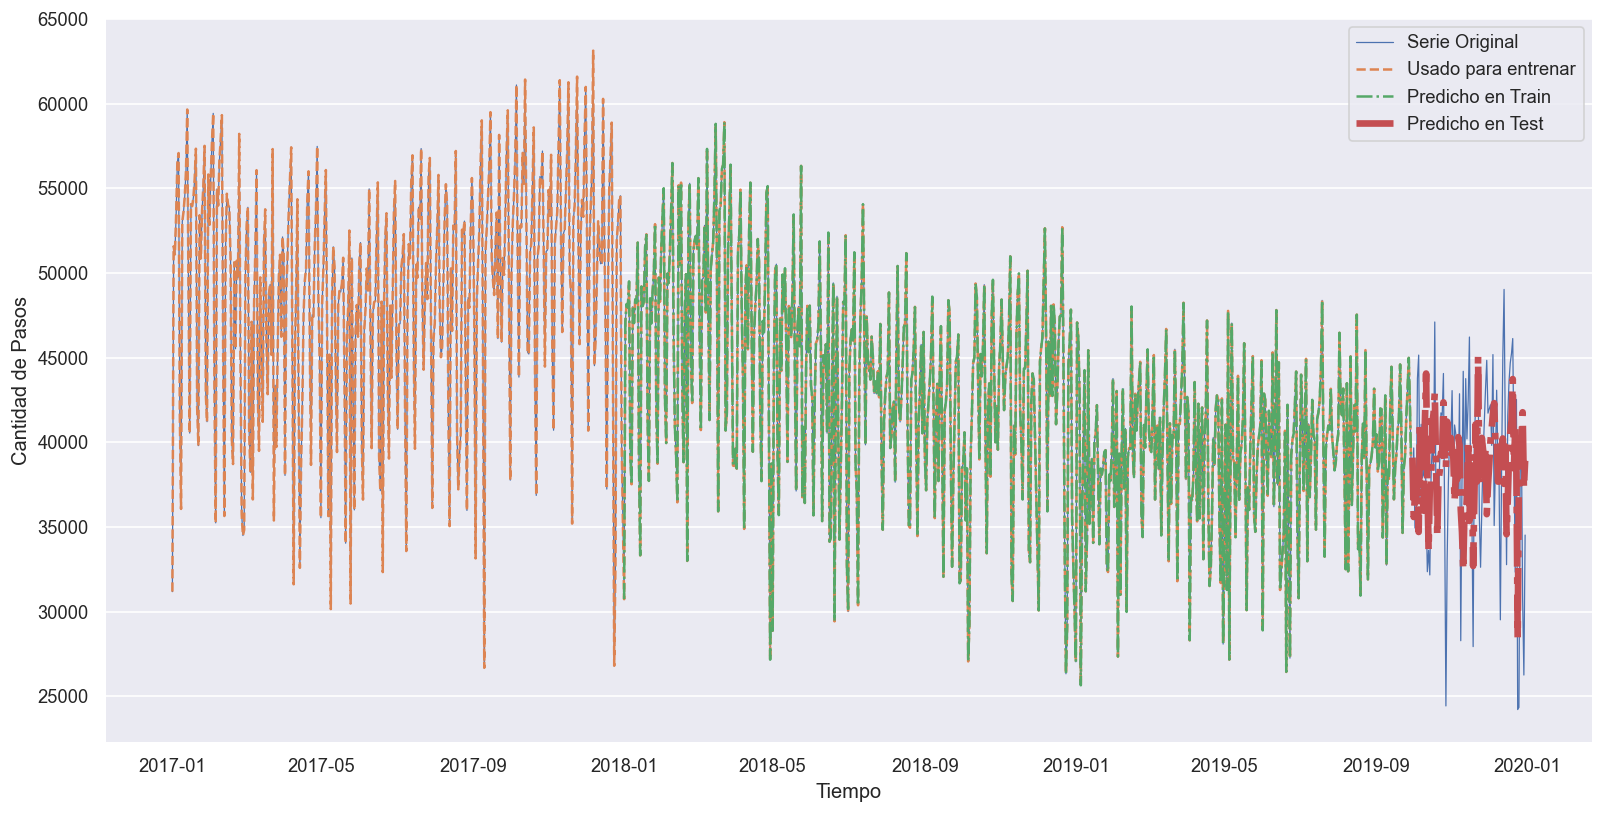

In [54]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

In [55]:
# Analizo el error de mediante el calculo el RMSE  y el MAPE en train y test
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('MAPE en Train: ',MAPE(y_train, y_train_pred))
print('MAPE en Test:', MAPE(y_test, y_test_pred))

RMSE en Train: 6.932271641190201
RMSE en Test: 5047.148932919557
MAPE en Train:  0.01322964391476959
MAPE en Test: 10.649208097523974


*  Visulamente la predicción no parece tan mala. Analizando el error del modelo observo que el  `MAPE` en test es igual a 10.64 en promedio lo que significa que `mi pronóstico está errado en un 10%`. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 5047 vehículos` por pasadas. 

### **Benchmark**

* Defino mi modelo de Benchmark como la comparación del error con el que habría obtenido si predecía copiando el valor de la fecha anterior.

In [56]:
#Defino mi predicción
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

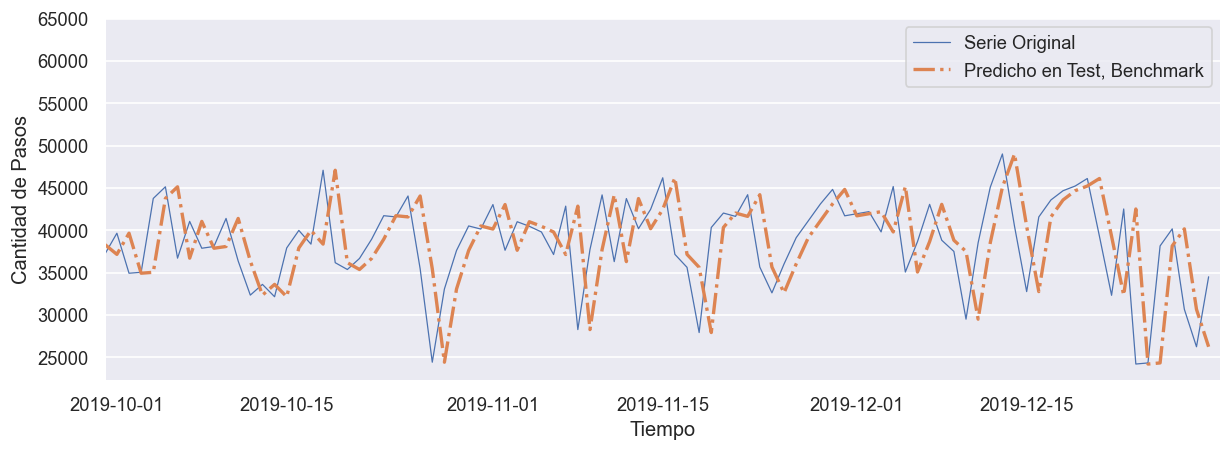

In [57]:
# Grafico comparativo entre la Serie Original y la Predicha en Test
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, 
         label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.grid(axis='x')
plt.show();

In [58]:
# Predigo
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

In [59]:
# Calculo el RMSE y el MAPE en test
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print('RMSE en Test:',np.sqrt(MSE))

print('MAPE en Test:', MAPE(y_test, y[-1 + N_train:N_train+N_test - 1]))

RMSE en Test: 6034.584014066429
MAPE en Test: 13.059929447146978


* Visualmente se observa la el dibujo de la serie desfazado en un día (tal cual definí mi modelo de BenchmarK). En cuanto al análisis de los errores en este caso,  el `MAPE` es igual a 13.06 en promedio lo que significa que `mi pronóstico está errado en un 13%`. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 6034 vehículos` por pasadas. Esto significa que me primer modelo obtuvo una mejor predicción que mi benchmark.

## Optimización de Hiperparámetros de mi modelo XGboost

* Mi suguiente paso será optimizar mi modelo de XGBoost ya que la predicción la realize con los valores por defecto. Para ello utilizaré el `randomsearchCV` para obtener los mejores hiperparémetros y ver si entrenando nuevamente el modelo con los hiperparametros obtenidos obtengo una mejor predicción.

In [60]:
# base parameters
params = {
    'max_depth': range (2, 20, 2),
    'min_child_weight': [4],
    'n_estimators': range(150,250,350),
    'colsample_bytree': [0.05,0.1,0.3,0.5,1],
    'learning_rate': [0.5, 0.1, 0.01, 0.05]
}

search_xpar = RandomizedSearchCV(xr, params, n_jobs=10, cv=10,
                                 verbose=True, scoring='neg_mean_squared_error')

search_xpar.fit(X_train, y_train)

print('Mejores Hiperparámetros: '+str(search_xpar.best_params_))
print('Mejor Score:'+str(search_xpar.best_score_)+'\n')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  4.2min finished


Mejores Hiperparámetros: {'n_estimators': 150, 'min_child_weight': 4, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.1}
Mejor Score:-19675297.849033065



In [61]:
# Defino el modelo con los mejores Hiperpáremtros obtenidos 

xr_b = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=150, max_depth=12, learning_rate= 0.05,
                        min_child_weight=4,colsample_bytree=0.1, random_state=42)

# Entreno  el modelo 
xr_b.fit(X_train,y_train)

# Predigo 
y_pred = xr_b.predict(X)
y_train_pred = xr_b.predict(X_train)
y_test_pred = xr_b.predict(X_test)

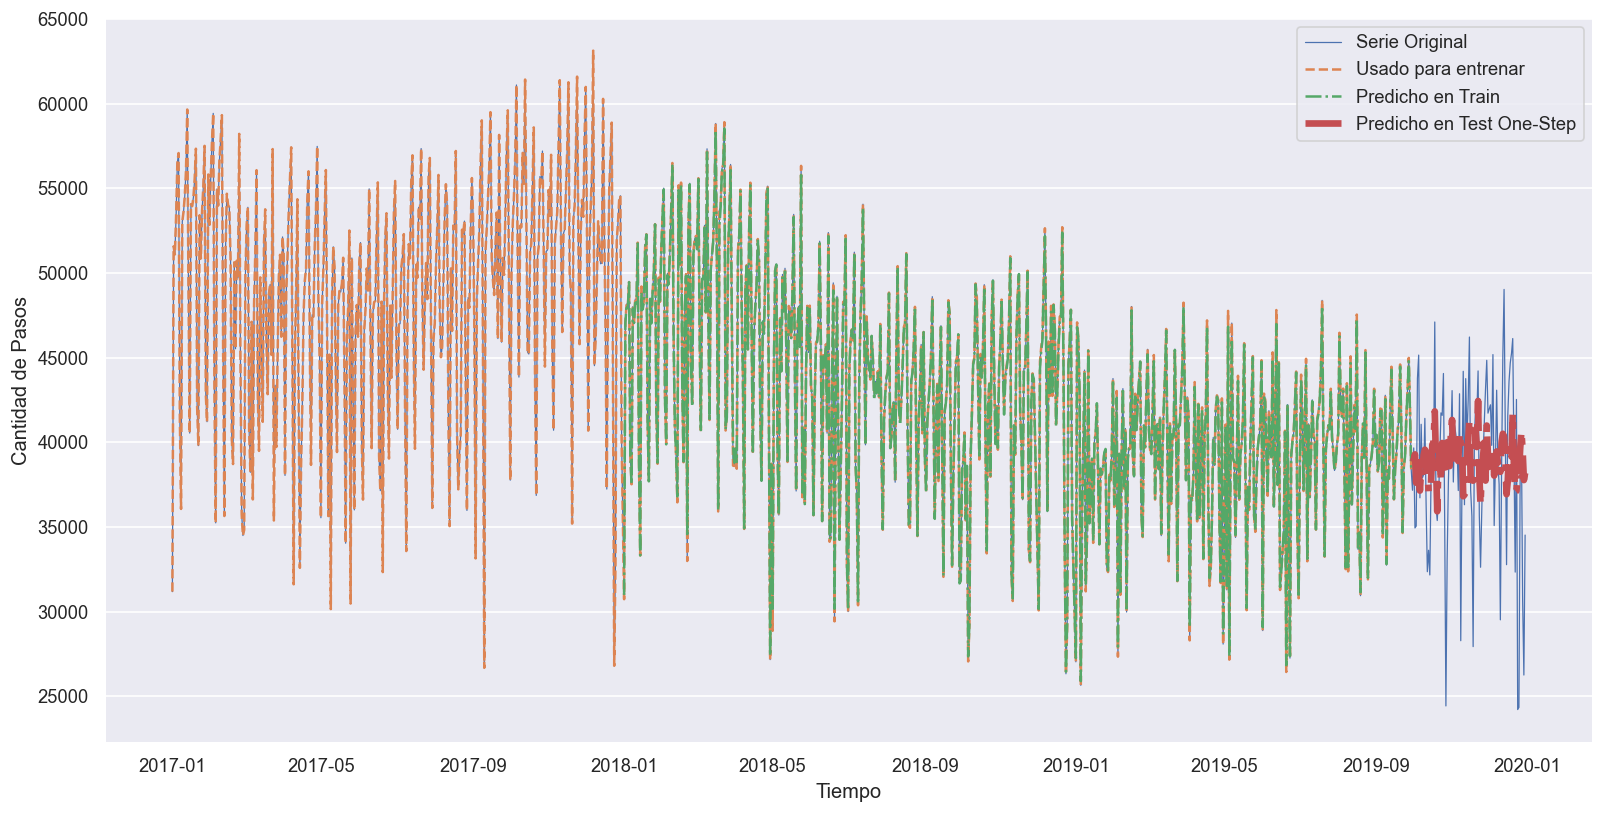

In [62]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test con el One-Step
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test One-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

In [63]:
# Calculo el RMSE  y el MAPE en train y test
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('MAPE en Train: ',MAPE(y_train, y_train_pred))
print('MAPE en Test:', MAPE(y_test, y_test_pred))

RMSE en Train: 187.01801943229611
RMSE en Test: 4713.488333295154
MAPE en Train:  0.27072702340877147
MAPE en Test: 10.01627835933582


* Mi modelo XGboost con los hiperparametros optimizados arroja un `MAPE` en test que es igual a 10.26 en promedio lo que significa que `mi pronóstico está errado en un 10%` no cambia mucho con respecto al modelo sin optimizar. Con respecto al `RMSE` tengo un diferencia que oscila entre `+/- 4698 vehículos` por pasadas esto si mejora logrando reducir en     el margen de error por más o por menos.

### Multi-Step Prediction

Con este último modelo entrenado con los hiperparametros optimizados, aplicaré el método recursivo para hacer Multi-Step prediction, es decir arranco con la primera instancia del conjunto de test y con la ventana de 365 días genero la predicción para el último trimestre del 2019.

In [64]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = xr_b.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

In [65]:
print(N_train+look_back)
print(length_total)

1002
1094


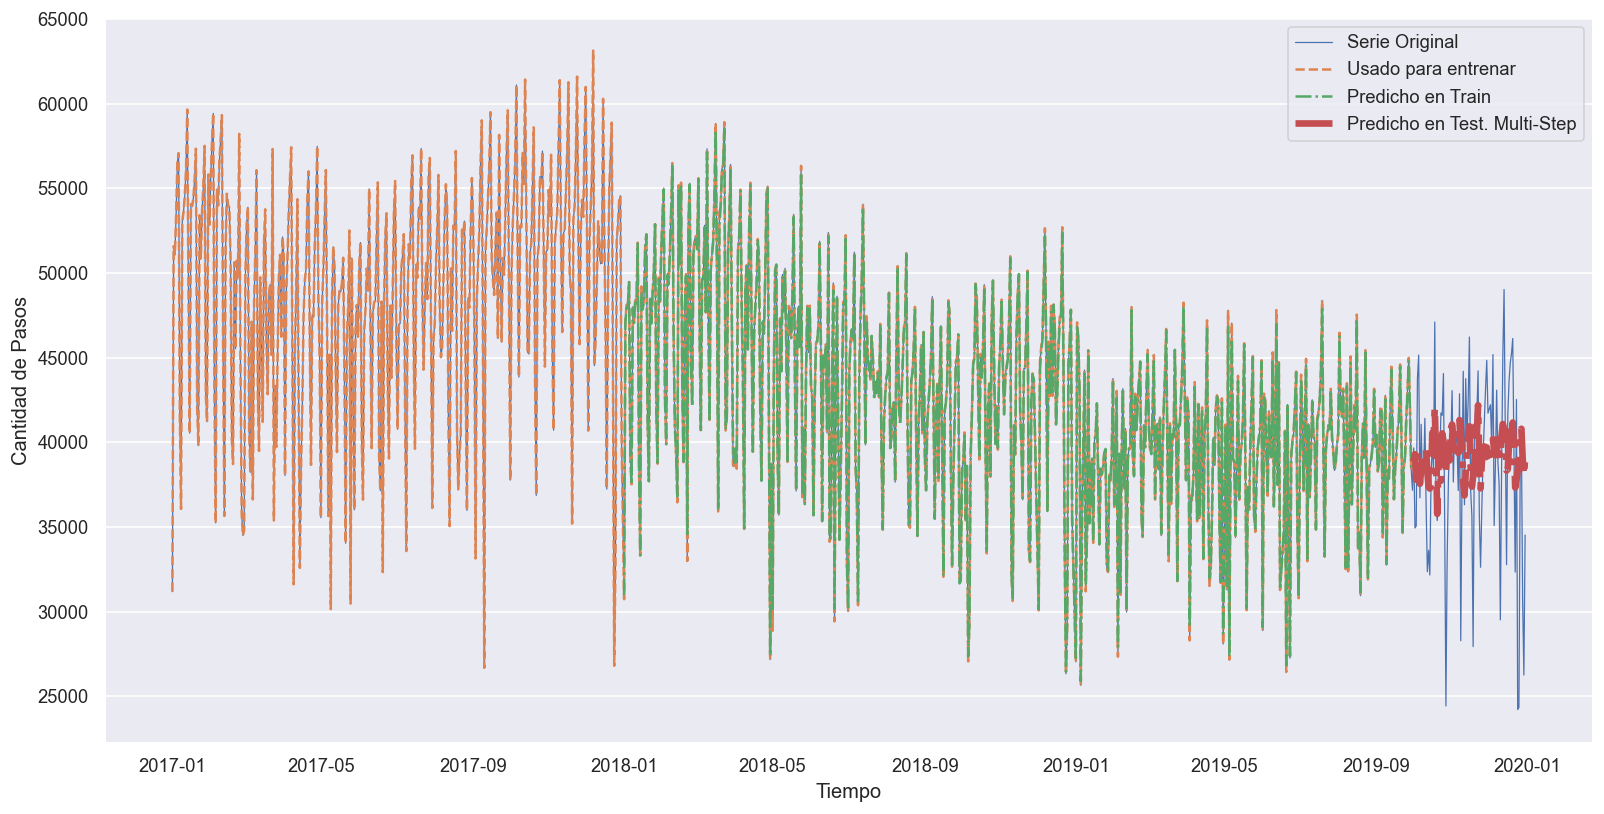

In [66]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test con el Multi-Step
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

In [67]:
# Calculo el RMSE y el MAPE en train y test
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_ms_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

# Calculo el MAPE en train y test
print('MAPE en Train: ',MAPE(y_train, y_train_pred))
print('MAPE en Test:', MAPE(y_test, y_test_pred))

RMSE en Train: 187.01801943229611
RMSE en Test: 4721.889478070807
MAPE en Train:  0.27072702340877147
MAPE en Test: 10.01627835933582


* A simple vista se observa que la predicción aplicando el método `Multi-Step prediction` no fue tan buena esto tambien que en evidencia con los valores arrojados tanto para el `MAPE` como para el `RMSE`. Como conclusión, elijo como la mejor predicción del último trimestre del 2019 la obtenida a través del método de la venana deslizante `One-Step Prediction`.

## Predicción a Futuro (año 2020)

* Para realizar dicha predicción necesito generar todas las fechas de dicho año para poder con el modelo elegido realizar la prediccion del mismo. Para ello a partir del último valor de mi serie genero mediante la utilización de la función de pandas `datatime.timedelta` la siguientes fechas.

In [68]:
senial.shape

(1095,)

In [69]:
# Me paro en el último día de mi serie diario
diario.index[-1]

Timestamp('2019-12-31 00:00:00', freq='D')

In [70]:
# Con esta función de panda le sumo un día.
diario.index[-1]+datetime.timedelta(days=1)

Timestamp('2020-01-01 00:00:00', freq='D')

In [71]:
# A través de un for voy a generar todo el 2020.
days_2020=[]
primerdia = diario.index[-1]+datetime.timedelta(days=1)
for i in range(0,366):
    nextday = primerdia + datetime.timedelta(days=i)
    days_2020.append(nextday)    

In [72]:
days_2020

[Timestamp('2020-01-01 00:00:00', freq='D'),
 Timestamp('2020-01-02 00:00:00', freq='D'),
 Timestamp('2020-01-03 00:00:00', freq='D'),
 Timestamp('2020-01-04 00:00:00', freq='D'),
 Timestamp('2020-01-05 00:00:00', freq='D'),
 Timestamp('2020-01-06 00:00:00', freq='D'),
 Timestamp('2020-01-07 00:00:00', freq='D'),
 Timestamp('2020-01-08 00:00:00', freq='D'),
 Timestamp('2020-01-09 00:00:00', freq='D'),
 Timestamp('2020-01-10 00:00:00', freq='D'),
 Timestamp('2020-01-11 00:00:00', freq='D'),
 Timestamp('2020-01-12 00:00:00', freq='D'),
 Timestamp('2020-01-13 00:00:00', freq='D'),
 Timestamp('2020-01-14 00:00:00', freq='D'),
 Timestamp('2020-01-15 00:00:00', freq='D'),
 Timestamp('2020-01-16 00:00:00', freq='D'),
 Timestamp('2020-01-17 00:00:00', freq='D'),
 Timestamp('2020-01-18 00:00:00', freq='D'),
 Timestamp('2020-01-19 00:00:00', freq='D'),
 Timestamp('2020-01-20 00:00:00', freq='D'),
 Timestamp('2020-01-21 00:00:00', freq='D'),
 Timestamp('2020-01-22 00:00:00', freq='D'),
 Timestamp

In [73]:
# Transformo mi lista en una serie creando la fecha como índice
serie = pd.Series(index=days_2020)
serie

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
              ..
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN
Length: 366, dtype: float64

In [74]:
# Por último uno el año 2020 generado a mi serie (senial)
nsenial = pd.concat([senial, serie])

In [75]:
nsenial.shape

(1461,)

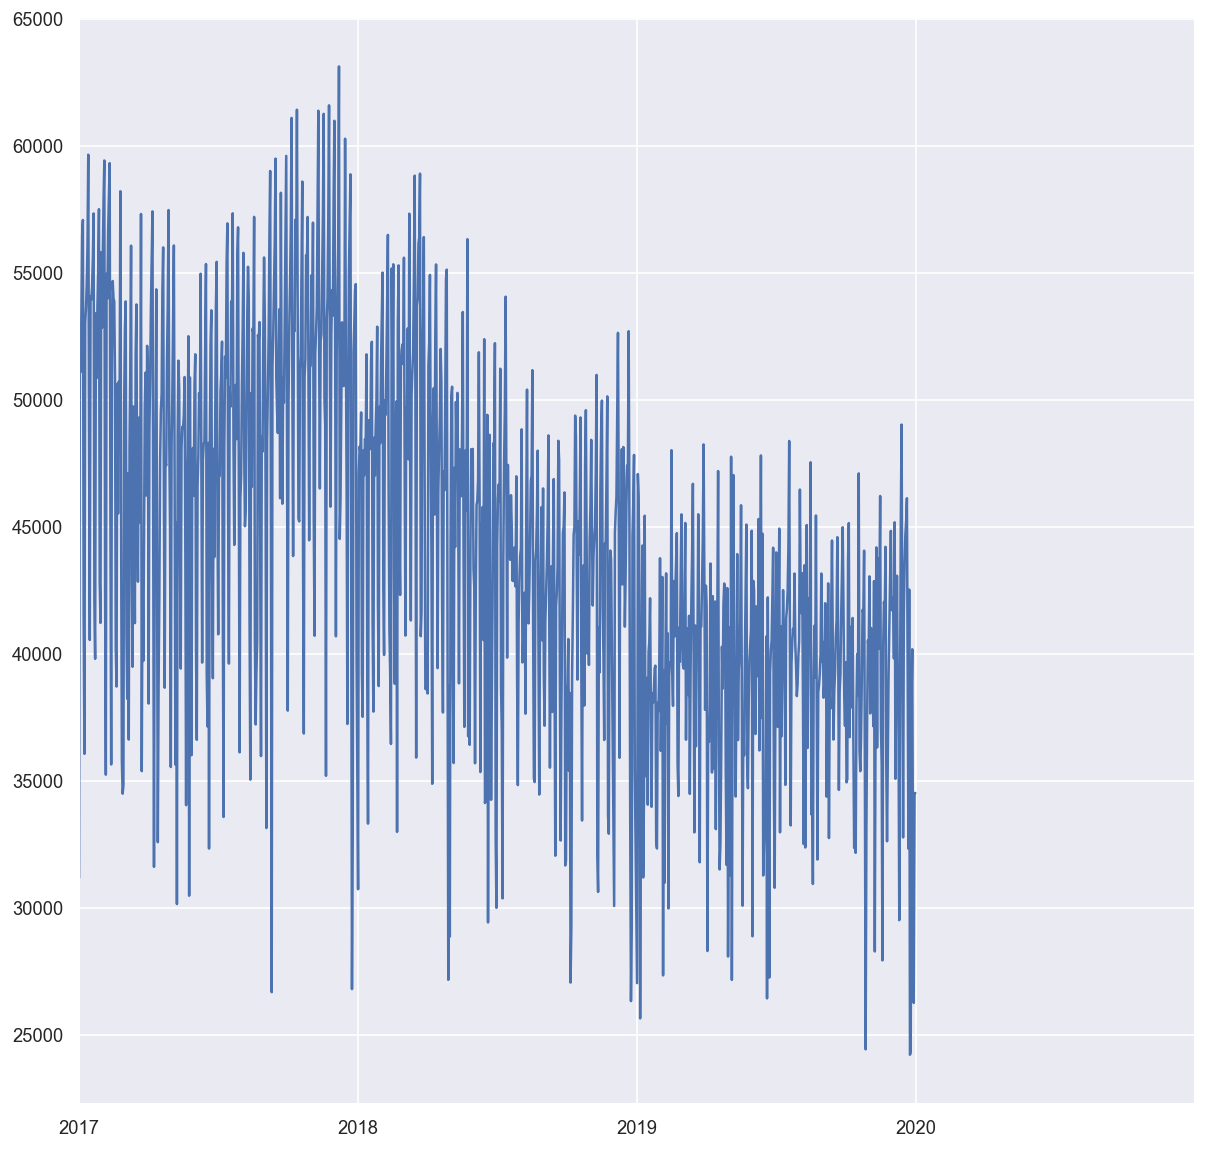

In [76]:
# Dibujo mi nuevo dataset
nsenial.plot() 

In [77]:
# Creo los X e y con ceros para luego llenar con los datos con mi nuevo dataset.
N = nsenial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1095, 365) (1095,)


In [78]:
#Llenamos los X y los y
for i in range(X.shape[0]):
    X[i,:] = nsenial.iloc[i:i+look_back]
    y[i] = nsenial.iloc[i+look_back]

In [79]:
# Definimos nuestros datos de Train y Test (Manteniendo mi look_back de 365 días)
N_train = (365*2) + (364) - look_back # cantidad de instancias que vamos a usar para entrenar. (2 años)
N_test = 366  #cantidad de puntos que vamos a usar para evaluar (1 año)
N_total = N_train + N_test
print(N_total)
length_total = N_train + N_test + look_back

print (length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

1095
1460
(729, 365) (729,)
(366, 365) (366,)


In [80]:
X_test[0,:] 

array([29840.66666667, 27038.        , 47080.        , 46194.        ,
       42887.        , 25650.        , 35546.        , 39580.        ,
       44266.        , 31199.        , 34330.        , 45439.        ,
       35187.        , 37122.        , 39057.        , 34062.        ,
       40063.        , 40492.        , 42189.        , 38084.5       ,
       33980.        , 38456.        , 38090.        , 38574.        ,
       39432.        , 39538.        , 32590.        , 32339.        ,
       38081.        , 37742.        , 39326.        , 43766.        ,
       36179.        , 38443.        , 43031.        , 27343.        ,
       39333.        , 30992.        , 39282.        , 43170.        ,
       37268.        , 40816.        , 29980.        , 39144.        ,
       39659.        , 39625.        , 48018.        , 39283.        ,
       37955.        , 42869.        , 40680.        , 42452.        ,
       43635.        , 44754.        , 35645.        , 34404.        ,
      

In [81]:
# Genero mi predicción (forecast) para el año 2020
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = xr_b.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

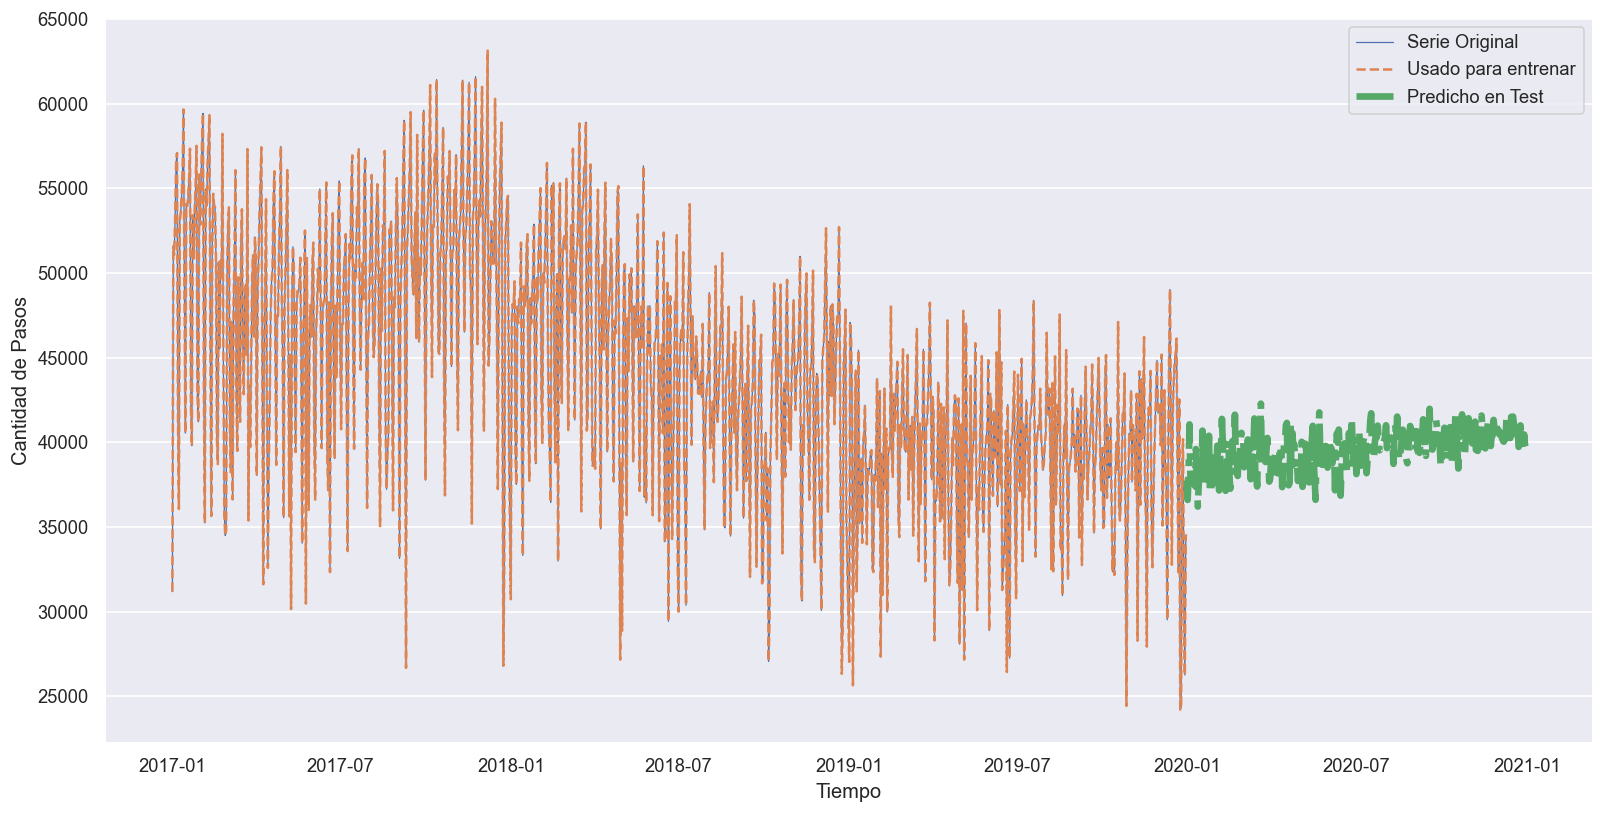

In [82]:
# Grafico comparativo entre la Serie Original, el Train y lo predicho en Train y Test.
plt.figure(figsize=(16,8))
plt.plot(nsenial.index[:length_total], nsenial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(nsenial.index[:N_train + look_back], nsenial[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(nsenial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(nsenial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.grid(axis='x')
plt.show();

* Se puede observar que la predicción que obtengo con mi modelo de XGBoost para el año 2020 no fue tan mala. Dicha predicción se obtiene con la información de un año para atrás por el cual su comportamiento resulta bastante parecido al año 2019. Teniendo mayor información (ventana hacia atrás) para predecir, en general, la predicción sería algo mejor pero para este caso en particular,  analizando la tendencia decreciente y el comportamiento de la serie considro que más información no mejoraría mucho la predicción que obtuve para el 2020.

In [83]:
serie.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)

In [84]:
# Genero mi forecast para el año 2020
forecast_2020 = pd.DataFrame(y_ms_test_pred, columns=['cantidad_pasos'],  index= serie.index)

In [85]:
forecast_2020.head(10)

cantidad_pasos
2020-01-01    37745.125000
2020-01-02    36595.242188
2020-01-03    38084.671875
2020-01-04    41060.355469
2020-01-05    37993.527344
2020-01-06    37832.421875
2020-01-07    37557.542969
2020-01-08    38129.125000
2020-01-09    38103.179688
2020-01-10    37418.621094

## Prediccion con Prophet

* Con el fin de comparar y además con la intención de aprender a utilizar esta librería creada por Facebook exclusivamente para el tratamiento de series de tiempo voy a predecir el año 2020 con Prophet.

In [86]:
# Vuelvo a mi dataset original. (Con la información desde el 1/01/2017 hasta el 31/12/2019)
diario.head()

cantidad_pasos    year  month  week  day
fecha                                               
2017-01-01         31183.0  2017.0    1.0  52.0  1.0
2017-01-02         51568.0  2017.0    1.0   1.0  2.0
2017-01-03         51093.0  2017.0    1.0   1.0  3.0
2017-01-04         53332.0  2017.0    1.0   1.0  4.0
2017-01-05         56486.0  2017.0    1.0   1.0  5.0

* La librería `Prophet` requiere para su utilización replantear la serie con el siguiente formato:
         ds ---> para representar la fecha (datetime stamp)
          y ---> para representar para variable objetivo,es decir, la que quiero predecir.

In [87]:
# Elimino la columna y transformo mi dataset tal cual lo requiere esta librería.
diario.drop(columns=['year','month','week','day'],inplace =True)

In [88]:
diario.head()

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0

In [89]:
df = diario.reset_index()
df.columns = ['ds', 'y']
df.head()

ds        y
0 2017-01-01  31183.0
1 2017-01-02  51568.0
2 2017-01-03  51093.0
3 2017-01-04  53332.0
4 2017-01-05  56486.0

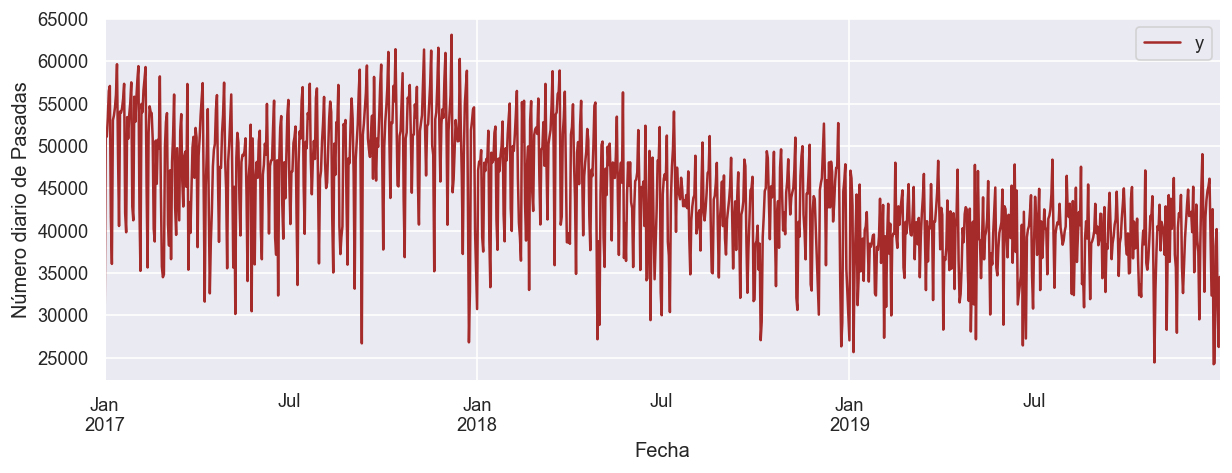

In [90]:
# Gráfico de las Pasadas Diarias
ax = df.set_index('ds').plot(figsize = (12, 4), color = 'brown')
ax.set_ylabel('Número diario de Pasadas')
ax.set_xlabel('Fecha')
plt.show();

In [91]:
# Defino mi modelo
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(df)

* Para predecir los valores usando el Prophet, necesitamos crear las datos con ds(datetime stamp) que contenga las fechas para las que quiero hacer las predicciones. Mediante la utilización de  `make_future_dataframe()` al cual le especifico el número de días que se extenderán hacia el futuro.

In [92]:
# Realizo mi predicción
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

In [93]:
forecast.tail(10)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
1451 2020-12-22  20339.388976  25060.014277  43145.074595  17499.792113   
1452 2020-12-23  20331.132616  26499.795557  45175.214087  17480.844382   
1453 2020-12-24  20322.876256  27568.974700  45308.287101  17461.896650   
1454 2020-12-25  20314.619896  29273.029300  48307.663151  17442.948919   
1455 2020-12-26  20306.363536  21927.829780  39837.513850  17424.001188   
1456 2020-12-27  20298.107177  17279.922592  35553.599853  17405.073081   
1457 2020-12-28  20289.850817  22337.323777  40997.411434  17386.178573   
1458 2020-12-29  20281.594457  23181.273420  41683.059388  17367.294701   
1459 2020-12-30  20273.338097  24856.628621  43733.380333  17348.414956   
1460 2020-12-31  20265.081737  26236.000790  44663.395783  17331.718189   

       trend_upper  additive_terms  additive_terms_lower  \
1451  23434.789003    13888.844460          13888.844460   
1452  23440.358740    15360.346337          15360.346337   
1453  23445.928476    16407.228048          16407.228048   
1454  23446.811615    18073.276647          18073.276647   
1455  23447.079921    10147.731300          10147.731300   
1456  23447.348226     5640.815403           5640.815403   
1457  23447.616532    11057.629789          11057.629789   
1458  23447.884837    11963.430524          11963.430524   
1459  23448.153143    13614.690679          13614.690679   
1460  23448.421449    14861.197511          14861.197511   

      additive_terms_upper         daily  ...       weekly  weekly_lower  \
1451          13888.844460  14181.246165  ...    26.300939     26.300939   
1452          15360.346337  14181.246165  ...  1837.363046   1837.363046   
1453          16407.228048  14181.246165  ...  3208.727837   3208.727837   
1454          18073.276647  14181.246165  ...  5179.908096   5179.908096   
1455          10147.731300  14181.246165  ... -2463.751052  -2463.751052   
1456           5640.815403  14181.246165  ... -6715.469523  -6715.469523   
1457          11057.629789  14181.246165  ... -1073.079345  -1073.079345   
1458          11963.430524  14181.246165  ...    26.300939     26.300939   
1459          13614.690679  14181.246165  ...  1837.363046   1837.363046   
1460          14861.197511  14181.246165  ...  3208.727837   3208.727837   

      weekly_upper       yearly  yearly_lower  yearly_upper  \
1451     26.300939  -318.702644   -318.702644   -318.702644   
1452   1837.363046  -658.262874   -658.262874   -658.262874   
1453   3208.727837  -982.745954   -982.745954   -982.745954   
1454   5179.908096 -1287.877614  -1287.877614  -1287.877614   
1455  -2463.751052 -1569.763814  -1569.763814  -1569.763814   
1456  -6715.469523 -1824.961239  -1824.961239  -1824.961239   
1457  -1073.079345 -2050.537031  -2050.537031  -2050.537031   
1458     26.300939 -2244.116580  -2244.116580  -2244.116580   
1459   1837.363046 -2403.918532  -2403.918532  -2403.918532   
1460   3208.727837 -2528.776491  -2528.776491  -2528.776491   

      multiplicative_terms  multiplicative_terms_lower  \
1451                   0.0                         0.0   
1452                   0.0                         0.0   
1453                   0.0                         0.0   
1454                   0.0                         0.0   
1455                   0.0                         0.0   
1456                   0.0                         0.0   
1457                   0.0                         0.0   
1458                   0.0                         0.0   
1459                   0.0                         0.0   
1460                   0.0                         0.0   

      multiplicative_terms_upper          yhat  
1451                         0.0  34228.233436  
1452                         0.0  35691.478953  
1453                         0.0  36730.104304  
1454                         0.0  38387.896543  
1455                         0.0  30454.094836  
1456                         0.0  25938.922580  
1457         

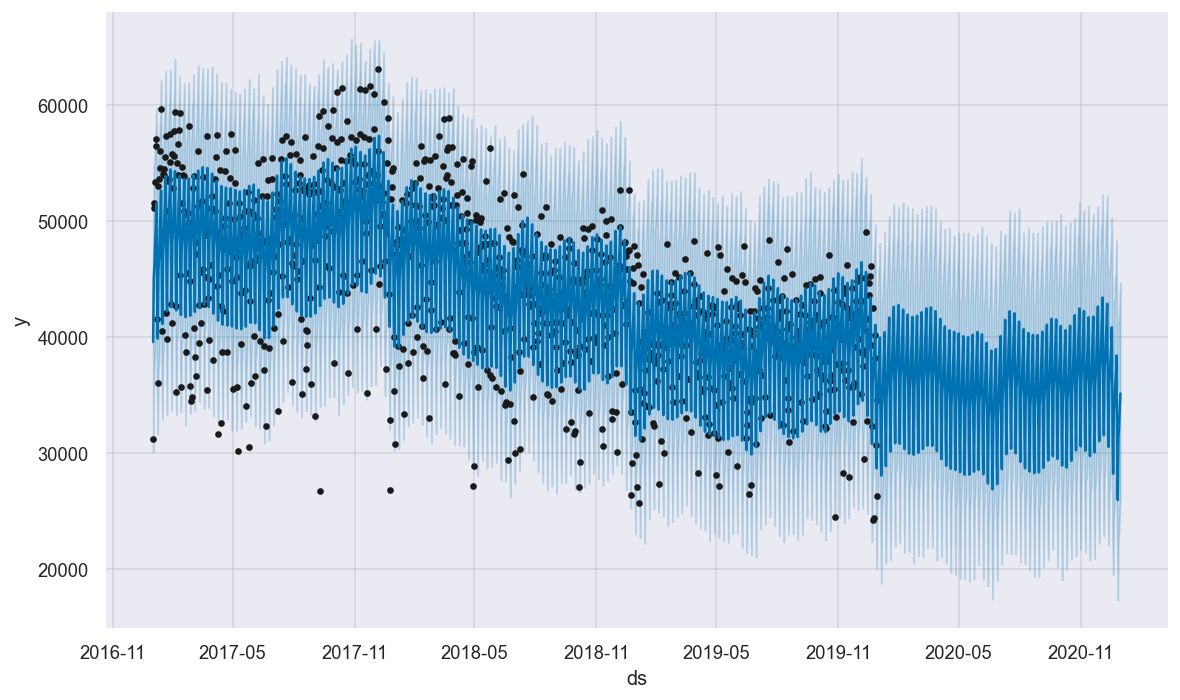

In [94]:
# Realizamos el gráfico de mi Forecast
m.plot(forecast);

* A través de la utilización de la función `plot_components()` podemos graficar los componentes del `forecast`, la tendencia y la estacionalidad.

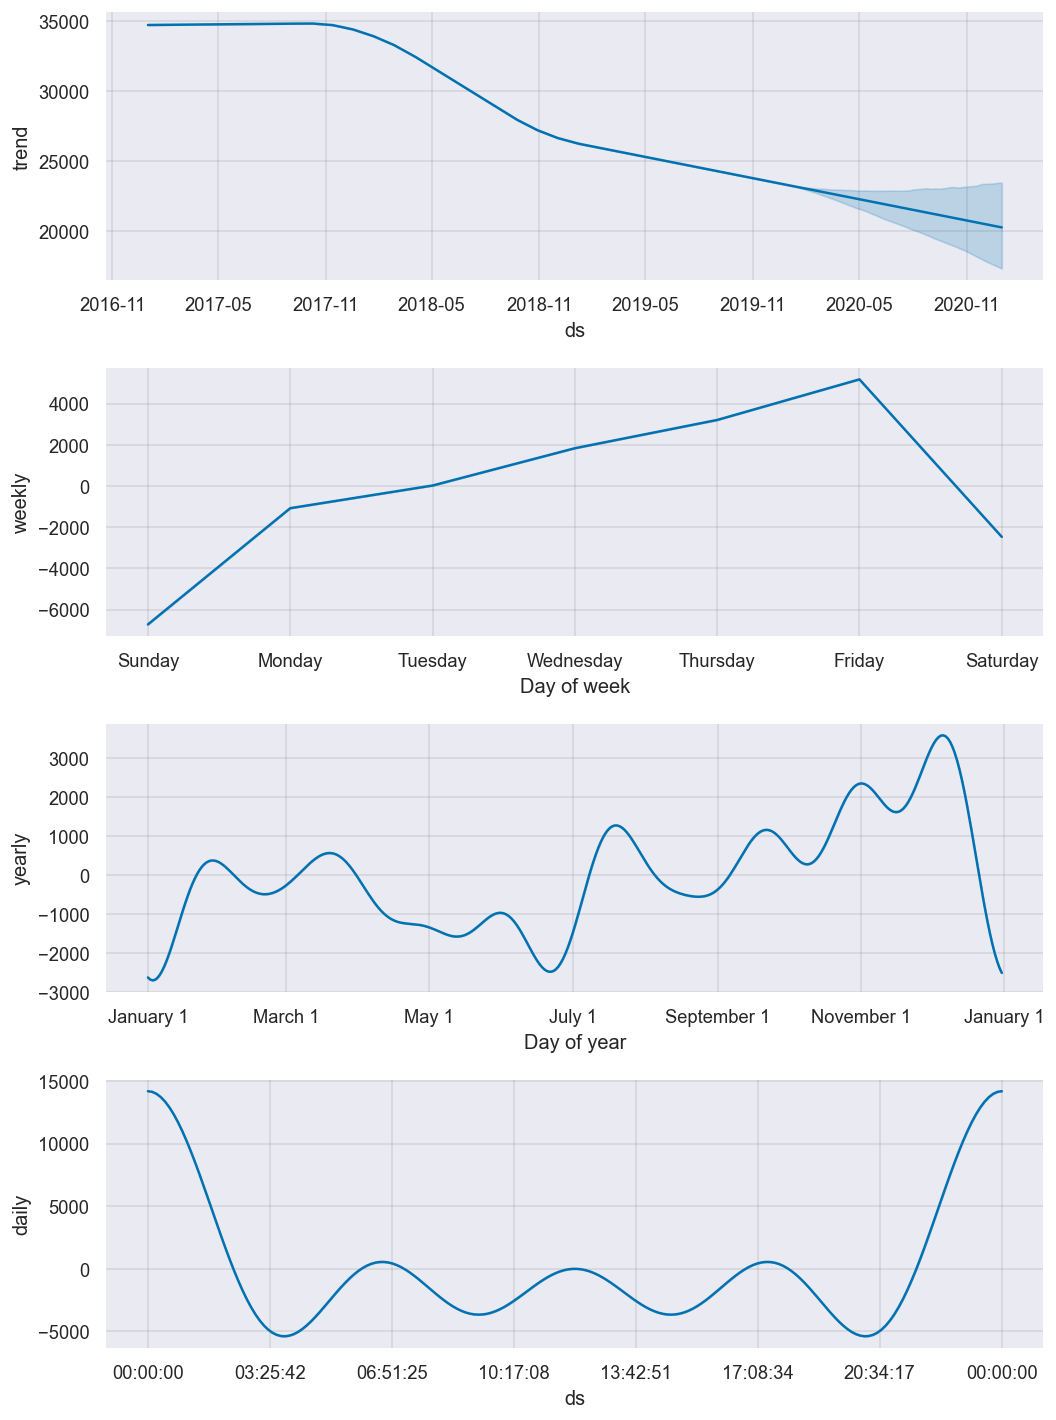

In [95]:
m.plot_components(forecast);

In [96]:
# Predicción con Prophet para fechas específicas
print(forecast[forecast.ds=='2020-04-10'].yhat)
forecast[forecast.ds=='2020-10-10'].yhat

1195    40912.564221
Name: yhat, dtype: float64


1378    32949.633285
Name: yhat, dtype: float64

In [97]:
# Predicción con mi modelo entrenado con XGboost para fechas específicas
print(forecast_2020.loc['2020-04-10 00:00:00'])
forecast_2020.loc['2020-10-10 00:00:00']

cantidad_pasos    39315.316406
Name: 2020-04-10 00:00:00, dtype: float32


cantidad_pasos    40817.371094
Name: 2020-10-10 00:00:00, dtype: float32

* En las dos ejecuciones de arriba imprimo la `predicción obtenida primero con Prophet y luego con mi modelo de XGboost entrenado para los mismas fechas del 2020` y se puede observar que al principio del 2020 (las primeras predicciones no están tan separadas) pero a medida que avanza el año la predicción con Prophet disminuye tal cual se veía en la tendencia pero en el caso del modelo predecido con XGboost la misma no decrece tanto y esto es tal cual muestra el grafico de la predicción con XGboost donde se visualiza que la predicción se mantiene oscilante alrededor de los 39000. 
 
Como desafío para mi proyecto 4 me propongo los siguientes puntos:
1. Definir dos modelos cada uno con un tipo de vehículo (Pesado y Liviano) ya que como se observa en el gráfico `cantidad de pasadas de acuerdo al sentido y al tipo de vehículo por días de semana`  el comportamiento entre tipo de vehículos es totalmente distinto.
1. Incluir más features para definir mi modelo tales como tipo de Vehículo, Sentido, Día de la semana y generar así nuevamente las predicciones para el último trimeste del 2019 y todo el 2020.
1. Optimizar el modelo obtenido con Prophet buscando los mejores hiperparametros para ello deberé investigar cuales son y como se realiza la optimización con dicha librería.
1. Realizar una comparación de la serie de tiempos entre las 3 estaciones de peajes con mayor tráfico vehicular.
* Por último realizaré las conclusiones necesarias luego de comprarar cada uno de los modelos obtenidos justificando mi elección.

# Para pensar, investigar y, opcionalmete, implementar

### Comparación de las series de entre los distintos peajes según forma de pago

* Voy estudiar el comportamiento de serie entre los distintos peajes pero solamente teniendo en cuenta como forma de pago Efectivo y Telepase.

In [98]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')

In [99]:
#Unimos los 4 datasets y lo hacemos directamente ya que tienen las mismas columnas
data = pd.concat([data_2019, data_2018, data_2017, data_2016])

In [100]:
data.shape

(4940149, 10)

In [101]:
data.forma_pago.value_counts()

EFECTIVO                1473556
TELEPASE                1027861
EXENTO                   633400
INFRACCION               545672
NO COBRADO               493728
AUPASS                   387616
TARJETA DISCAPACIDAD     287788
T. DISCAPACIDAD           76001
MONEDERO                  14519
Otros                         8
Name: forma_pago, dtype: int64

In [102]:
#Me quedo solamente con la forma de pago 'TELEPASE' y 'EFECTIVO'
mask = np.logical_or(data.forma_pago == 'EFECTIVO', data.forma_pago == 'TELEPASE')
data = data[mask]

#Quito las columnas que no voy a utilizar
data.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Paso la columna fecha a formato datetime, y le uno la hora_fin como hora
data['fecha2'] = pd.to_datetime(data.fecha) + pd.to_timedelta(data.hora_fin, unit = 'h')

#Quito las columnas fecha y hora_fin ya que las incluí en el campo fecha2
data.drop(columns=['fecha','hora_fin'], inplace = True)

#Correjo el nombre de fecha2 a fecha
data.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordeno el dataset por fecha
data.sort_values('fecha', inplace = True);
data.reset_index(drop=True, inplace = True)
data.head(15)

dia            estacion    sentido tipo_vehiculo forma_pago  \
0   Viernes  Dellepiane Liniers  Provincia        Pesado   EFECTIVO   
1   Viernes          Avellaneda     Centro        Pesado   EFECTIVO   
2   Viernes          Avellaneda     Centro        Pesado   EFECTIVO   
3   Viernes          Avellaneda     Centro        Pesado   EFECTIVO   
4   Viernes               Illia     Centro       Liviano   EFECTIVO   
5   Viernes   Dellepiane Centro     Centro        Pesado   EFECTIVO   
6   Viernes               Illia     Centro        Pesado   EFECTIVO   
7   Viernes             Alberdi  Provincia       Liviano   EFECTIVO   
8   Viernes  Dellepiane Liniers  Provincia        Pesado   EFECTIVO   
9   Viernes             Alberdi  Provincia       Liviano   EFECTIVO   
10  Viernes             Alberdi  Provincia        Pesado   EFECTIVO   
11  Viernes          Avellaneda  Provincia        Pesado   EFECTIVO   
12  Viernes          Avellaneda  Provincia        Pesado   EFECTIVO   
13  Viernes          Avellaneda  Provincia        Pesado   EFECTIVO   
14  Viernes          Avellaneda  Provincia        Pesado   EFECTIVO   

    cantidad_pasos      fecha  
0                1 2016-01-01  
1               10 2016-01-01  
2                6 2016-01-01  
3                2 2016-01-01  
4               14 2016-01-01  
5                1 2016-01-01  
6                2 2016-01-01  
7                6 2016-01-01  
8                5 2016-01-01  
9              177 2016-01-01  
10               1 2016-01-01  
11               1 2016-01-01  
12              18 2016-01-01  
13              17 2016-01-01  
14               3 2016-01-01

In [103]:
data.shape

(2501417, 7)

In [104]:
# Para poder realizar un mejor análisi y estudio de la serie por año creo la columna año
data['year']= data.fecha.dt.year

In [105]:
# Verifico las estaciones de peajes
data.estacion.unique()

array(['Dellepiane Liniers', 'Avellaneda', 'Illia', 'Dellepiane Centro',
       'Alberdi', 'Retiro', 'Salguero', 'Sarmiento', 'Dellepiane',
       'Alberti', 'PDB'], dtype=object)

In [106]:
# Unifico la estaciones Dellepiane Liniers, Centro todas en Dellepiane.
data.estacion=data.estacion.replace('Dellepiane Centro', 'Dellepiane')
data.estacion=data.estacion.replace('Dellepiane Liniers', 'Dellepiane')
data.estacion.unique()

array(['Dellepiane', 'Avellaneda', 'Illia', 'Alberdi', 'Retiro',
       'Salguero', 'Sarmiento', 'Alberti', 'PDB'], dtype=object)

In [107]:
# Reemplazo la estacion Alberdi por Alberti
data.estacion=data.estacion.replace('Alberti','Alberdi')

In [108]:
# Analizo la cantidad de pasadas por estacion de peaje
data.estacion.value_counts()

Avellaneda    668429
Dellepiane    618514
Illia         551178
Retiro        288984
Alberdi       262394
Salguero       46600
Sarmiento      44865
PDB            20453
Name: estacion, dtype: int64

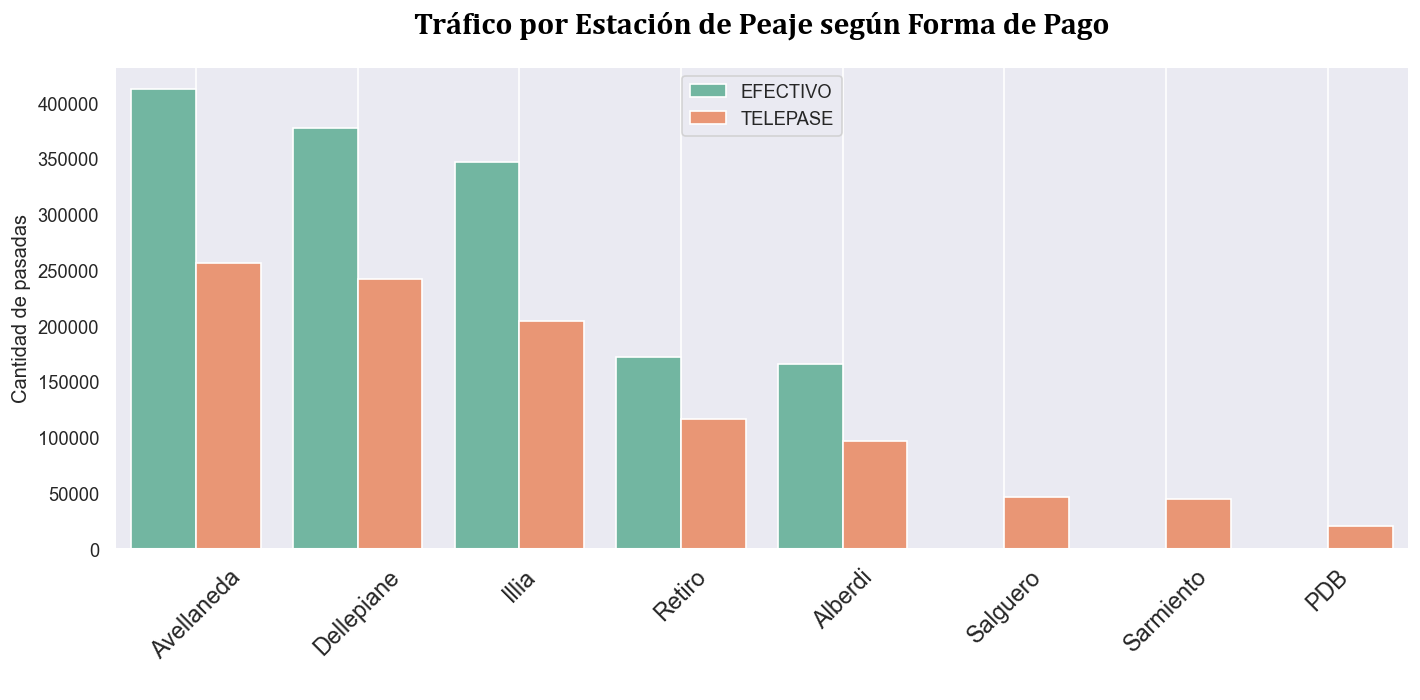

In [109]:
# Grafico la cantidad de pasadas por estacion teniendo en cuanta la forma de pago
#--------------------------------------------------------------------------------
plt.figure(figsize=(12,6))
ax = sns.countplot(x='estacion',
                   data=data, order=data['estacion'].value_counts().index, hue='forma_pago', palette= 'Set2')

ax.set_xticklabels(ax.get_xticklabels(), fontsize= 14, rotation=45)
plt.ylabel('Cantidad de pasadas')
plt.xlabel('  ')
plt.title('Tráfico por Estación de Peaje según Forma de Pago', pad= 20, fontdict = title_font )
plt.grid()
plt.legend()
plt.tight_layout()
plt.show();

* En el gráfico de arriba se observa que la estación Avellaneda, Dellepiane e Illia concentran la mayor cantidad de pasadas y en las tres se ve que la forma de pago TELEPASE está igualando a la forma de pago en EFECTIVO siendo esta última por ahora la más utilizada. 
* Otra punto que observo es que ya existen estaciones de peajes en las que solo se visualiza el TELEPASE como forma de pago (Salguero, Sarmiento y PDB) esto justifica la tendencia decreciente que presenta la serie analizada en la primer parte del proyecto ya que la misma analizaba solamente la forma de pago en EFECTIVO.

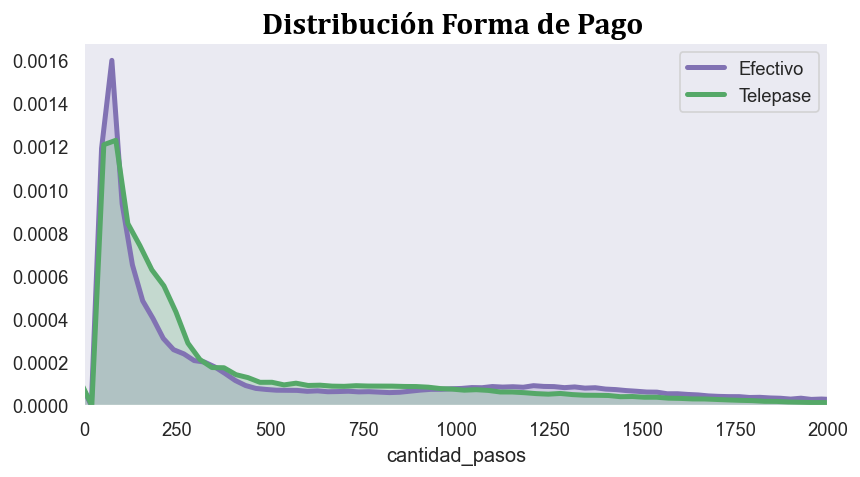

In [110]:
plt.figure(figsize=(8,4))
sns.distplot(a=data[data.forma_pago == 'EFECTIVO'].cantidad_pasos, hist=False, label= 'Efectivo', 
             kde_kws={'shade': True, 'lw': 3, 'color': 'm' })
sns.distplot(a=data[data.forma_pago == 'TELEPASE'].cantidad_pasos, hist=False, label= 'Telepase', 
             kde_kws={'shade': True, 'lw': 3, 'color': 'g' })
plt.title('Distribución Forma de Pago ' ,fontdict = title_font)
plt.xlim(0,2000)
plt.grid(False)
plt.show();

* En el gráfico de la Distribución de las formas de Pagos de acuerdo a la cantidad de pasadas se puede ver como la distribución de TELEPASE se está acercando a la de EFECTIVO. 

<Figure size 960x480 with 0 Axes>

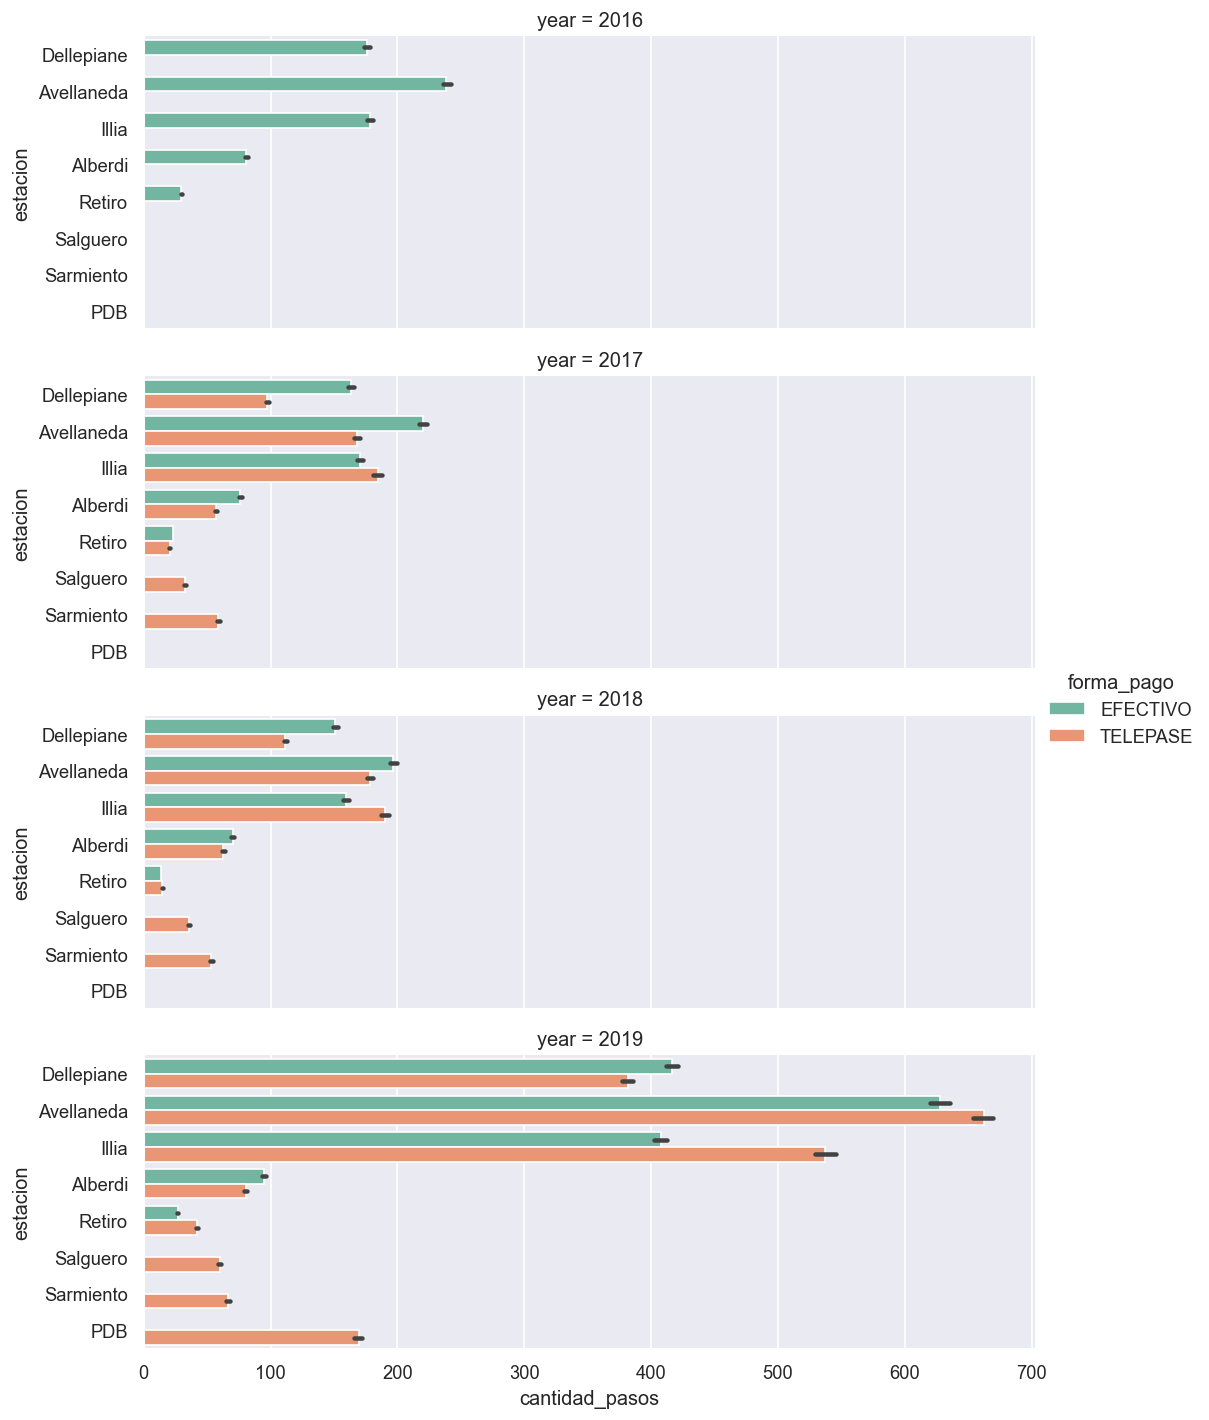

In [111]:
plt.figure(figsize=(8,4))
g = sns.catplot(x='cantidad_pasos', y='estacion',
                hue='forma_pago', row='year',
                data=data,
                orient='h', height=3, aspect=3, palette="Set2",
                kind='bar')
plt.show();

* Analizando el comportamiento de la cantidad de pasadas según las estaciones de peajes y formas de pagos por año se visualiza nuevamente que la forma de pago a través del TELEPASE viene creciendo año a año. Se observa que en el año 2016 solo se utilizaba como forma de pago el EFECTIVO mientras que ya en el 2019 en las estaciones de peaje con mayor flujo vehicular tienen casi igual la forma de pago EFECTIVO y TELEPASE e inclusive ya se visualiza estaciones de peaje donde solo se utiliza como forma de pago el TELEPASE.